In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

In [88]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error
from xgboost import plot_importance, plot_tree
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.utils.validation import check_is_fitted

In [4]:
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.filterwarnings("ignore", category=SettingWithCopyWarning)

# Load dataset

In [5]:
def preprocess_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        for i, line in enumerate(file):
            if 'datetime' in line.lower():
                return i
    return None

In [6]:
def read_files(file_path, batch_size=10):
    files = [os.path.join(file_path, f) for f in sorted(os.listdir(file_path)) if f.endswith('.csv')]
    all_data = []

    for i in range(0, len(files), batch_size):
        batch_files = files[i:i + batch_size]
        batch_data = []

        for file_name in batch_files:
            header_index = preprocess_file(file_name)
            if header_index is not None:
                df = pd.read_csv(file_name, header=header_index)
                batch_data.append(df)

        if batch_data:
            batch_df = pd.concat(batch_data, ignore_index=True)
            all_data.append(batch_df)

    final_data = pd.concat(all_data, ignore_index=True)
    return final_data

In [7]:
file_path = 'C:/Users/mrudu/Downloads/weatherdata_for_students/weatherdata_for_students'
brighton_data = read_files(file_path, batch_size=10)

In [8]:
brighton_data.shape

(122844, 16)

In [9]:
brighton_data.head(3)

,datetime,temp,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,solarradiation,solarenergy,uvindex
0,2010-01-01T00:00:00,1.9,-0.5,84.25,0.417,100.0,"rain,snow",0.0,0.0,19.4,11.0,999.9,62.2,0.0,0.0,0.0
1,2010-01-01T01:00:00,1.9,-0.5,83.90,0.000,0.0,NaN,0.0,0.0,21.8,19.0,999.8,22.4,0.0,0.0,0.0
2,2010-01-01T02:00:00,1.4,-0.7,85.76,0.000,0.0,NaN,0.0,0.0,17.7,10.0,1000.0,38.0,0.0,0.0,0.0


In [10]:
brighton_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122844 entries, 0 to 122843
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   datetime          122844 non-null  object 
 1   temp              122590 non-null  float64
 2   dew               122568 non-null  float64
 3   humidity          122575 non-null  float64
 4   precip            122565 non-null  float64
 5   precipprob        122558 non-null  float64
 6   preciptype        11277 non-null   object 
 7   snow              89810 non-null   float64
 8   snowdepth         89279 non-null   float64
 9   windspeed         122583 non-null  float64
 10  winddir           122567 non-null  float64
 11  sealevelpressure  122319 non-null  float64
 12  cloudcover        122556 non-null  float64
 13  solarradiation    122514 non-null  float64
 14  solarenergy       122480 non-null  float64
 15  uvindex           122486 non-null  float64
dtypes: float64(14), obje

In [11]:
brighton_data.to_csv('brighton_data.csv', index=False)

In [12]:
df= brighton_data.copy()

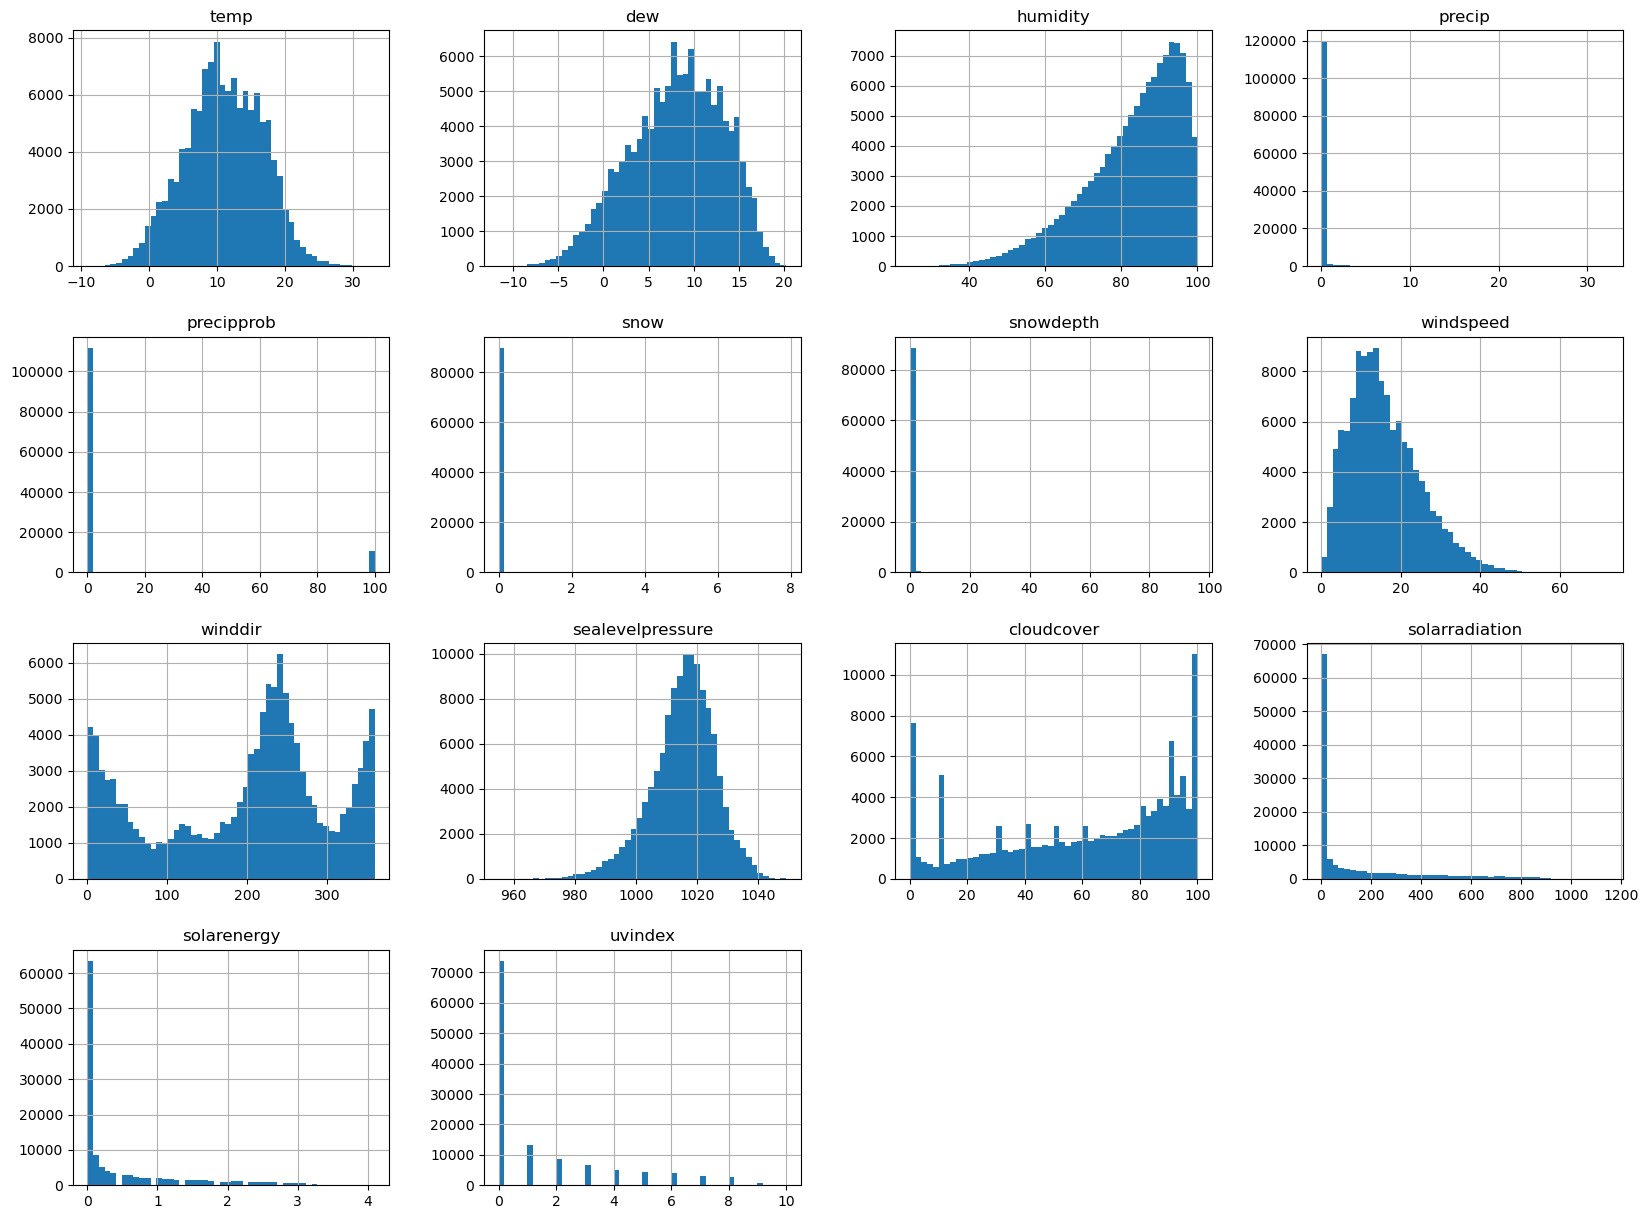

In [13]:
_ = df.hist(bins=50, figsize=(20,15))

In [14]:
df.describe()

,temp,dew,humidity,precip,precipprob,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,solarradiation,solarenergy,uvindex
count,122590.000000,122568.000000,122575.000000,122565.000000,122558.000000,89810.000000,89279.000000,122583.000000,122567.000000,122319.000000,122556.000000,122514.000000,122480.000000,122486.000000
mean,11.059431,8.047911,82.880536,0.081954,8.883141,0.000408,0.028941,15.938294,196.561486,1015.525463,60.841873,138.575974,0.498450,1.368646
std,5.654195,5.136014,12.511270,0.660720,28.450141,0.034549,0.441740,8.903724,106.273116,10.519485,31.879025,220.733866,0.795407,2.225490
min,-9.100000,-11.600000,24.340000,0.000000,0.000000,0.000000,0.000000,0.000000,0.700000,955.000000,0.000000,0.000000,0.000000,0.000000
25%,7.200000,4.500000,75.560000,0.000000,0.000000,0.000000,0.000000,9.400000,113.000000,1009.600000,36.000000,0.000000,0.000000,0.000000
50%,11.000000,8.400000,85.700000,0.000000,0.000000,0.000000,0.000000,14.400000,223.000000,1016.400000,68.400000,9.000000,0.000000,0.000000
75%,15.300000,12.000000,92.790000,0.000000,0.000000,0.000000,0.000000,21.300000,267.000000,1022.500000,89.800000,201.000000,0.700000,2.000000
max,33.300000,20.200000,100.000000,32.385000,100.000000,7.870000,96.000000,72.200000,360.000000,1049.300000,100.000000,1150.000000,4.100000,10.000000


In [15]:
df.isnull().sum()

datetime                 0
temp                   254
dew                    276
humidity               269
precip                 279
precipprob             286
preciptype          111567
snow                 33034
snowdepth            33565
windspeed              261
winddir                277
sealevelpressure       525
cloudcover             288
solarradiation         330
solarenergy            364
uvindex                358
dtype: int64

# Preprocessing

In [16]:
# Convert 'datetime' column to datetime data type
df['datetime'] = pd.to_datetime(df['datetime'])

# Set 'datetime' column as the index
df.set_index('datetime', inplace=True)

Duplicates

In [17]:
# Check for duplicates in the datetime index
duplicate_index = df.index[df.index.duplicated(keep=False)]

# Display the rows where the datetime index is duplicated
duplicate_rows = df.loc[duplicate_index]

# Count the number of duplicate datetime entries
number_of_duplicates = duplicate_rows.index.duplicated(keep=False).sum()

# Output the number of duplicates and the duplicate rows
number_of_duplicates, duplicate_rows

(56,
                      temp   dew  humidity  precip  precipprob preciptype  \
 datetime                                                                   
 2010-10-31 01:00:00  12.4  10.6     88.49   0.000         0.0        NaN   
 2010-10-31 01:00:00  12.4  10.3     87.33   0.000         0.0        NaN   
 2010-10-31 01:00:00  12.4  10.6     88.49   0.000         0.0        NaN   
 2010-10-31 01:00:00  12.4  10.3     87.33   0.000         0.0        NaN   
 2011-10-30 01:00:00  14.2  12.3     88.87   0.000         0.0        NaN   
 2011-10-30 01:00:00  14.4  12.5     88.08   0.000         0.0        NaN   
 2011-10-30 01:00:00  14.2  12.3     88.87   0.000         0.0        NaN   
 2011-10-30 01:00:00  14.4  12.5     88.08   0.000         0.0        NaN   
 2012-10-28 01:00:00   2.6   0.9     88.68   0.112       100.0       rain   
 2012-10-28 01:00:00   2.5   0.7     87.94   0.000         0.0        NaN   
 2012-10-28 01:00:00   2.6   0.9     88.68   0.112       100.0       ra

In [18]:
# Remove duplicate entries, keeping only the first occurrence for each datetime index
df_final = df[~df.index.duplicated(keep='first')]
df_final.sort_index(inplace=True)
remaining_duplicates = df_final.index[df_final.index.duplicated(keep=False)]
df_final.info(), remaining_duplicates

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 122830 entries, 2010-01-01 00:00:00 to 2024-01-06 11:00:00
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   temp              122576 non-null  float64
 1   dew               122554 non-null  float64
 2   humidity          122561 non-null  float64
 3   precip            122551 non-null  float64
 4   precipprob        122544 non-null  float64
 5   preciptype        11275 non-null   object 
 6   snow              89800 non-null   float64
 7   snowdepth         89269 non-null   float64
 8   windspeed         122569 non-null  float64
 9   winddir           122553 non-null  float64
 10  sealevelpressure  122305 non-null  float64
 11  cloudcover        122542 non-null  float64
 12  solarradiation    122500 non-null  float64
 13  solarenergy       122466 non-null  float64
 14  uvindex           122472 non-null  float64
dtypes: float64(14), object(1)
memory u

(None, DatetimeIndex([], dtype='datetime64[ns]', name='datetime', freq=None))

In [19]:
# create a complete hourly datetime range from the start to the end
expected_range = pd.date_range(start=df_final.index.min(), end=df_final.index.max(), freq='H')

# Reindex the DataFrame to complete datetime range to find any missing datetime values
df_reindexed = df_final.reindex(expected_range)
missing_datetimes = df_reindexed[df_reindexed.isnull().all(axis=1)]

# Display the number and details of missing datetime values
missing_datetimes_count = missing_datetimes.shape[0]
missing_datetimes_info = missing_datetimes.index.tolist()

missing_datetimes_count, missing_datetimes_info


(14,
 [Timestamp('2010-03-28 01:00:00'),
  Timestamp('2011-03-27 01:00:00'),
  Timestamp('2012-03-25 01:00:00'),
  Timestamp('2013-03-31 01:00:00'),
  Timestamp('2014-03-30 01:00:00'),
  Timestamp('2015-03-29 01:00:00'),
  Timestamp('2016-03-27 01:00:00'),
  Timestamp('2017-03-26 01:00:00'),
  Timestamp('2018-03-25 01:00:00'),
  Timestamp('2019-03-31 01:00:00'),
  Timestamp('2020-03-29 01:00:00'),
  Timestamp('2021-03-28 01:00:00'),
  Timestamp('2022-03-27 01:00:00'),
  Timestamp('2023-03-26 01:00:00')])

In [20]:
df_reindexed.isnull().sum()

temp                   268
dew                    290
humidity               283
precip                 293
precipprob             300
preciptype          111569
snow                 33044
snowdepth            33575
windspeed              275
winddir                291
sealevelpressure       539
cloudcover             302
solarradiation         344
solarenergy            378
uvindex                372
dtype: int64

Missing values and Feature selection

For solar energy prediction we are going to consider the following variables: Solar Radiation, CLoud Cover, Temperature, Time features, UV Index

We are going to delete the following features: precipitation variables, wind direction, dew point, sealevelpressure, snow depth and snow

In [21]:
# Columns to be dropped
columns_to_drop = ['precip', 'precipprob', 'preciptype', 'winddir', 'dew', 'sealevelpressure', 'snowdepth', 'snow']

# Drop the specified columns from the DataFrame
df_reindexed = df_reindexed.drop(columns=columns_to_drop)
df_reindexed.columns

Index(['temp', 'humidity', 'windspeed', 'cloudcover', 'solarradiation',
       'solarenergy', 'uvindex'],
      dtype='object')

Filling Missing values

In [22]:
#columns to interpolate
columns_to_interpolate = ['temp', 'humidity', 'windspeed', 'cloudcover', 'solarenergy', 'solarradiation', 'uvindex']

for column in columns_to_interpolate:
    df_reindexed[column] = df_reindexed[column].interpolate(method='linear')

In [23]:
df_reindexed.isnull().sum()

temp              0
humidity          0
windspeed         0
cloudcover        0
solarradiation    0
solarenergy       0
uvindex           0
dtype: int64

In [24]:
df_reindexed['date'] = df_reindexed.index.date

df_reindexed['year'] = df_reindexed.index.year
df_reindexed['month'] = df_reindexed.index.month
df_reindexed['day'] = df_reindexed.index.day
df_reindexed['time'] = df_reindexed.index.time
df_reindexed['hour'] = df_reindexed.index.hour
#'day_of_week' represents the weekday as an integer, with Monday=0 and Sunday=6
df_reindexed['day_of_week'] = df_reindexed.index.dayofweek
df_reindexed['week_of_year'] = df_reindexed.index.isocalendar().week
df_reindexed['day_of_year'] = df_reindexed.index.dayofyear
def get_season(month):
    if month in [12, 1, 2]:  # December, January, February: Winter
        return '1'
    elif month in [3, 4, 5]:  # March, April, May: Spring
        return '2'
    elif month in [6, 7, 8]:  # June, July, August: Summer
        return '3'
    elif month in [9, 10, 11]:  # September, October, November: Autumn
        return '4'
df_reindexed['season'] = df_reindexed.index.month.map(get_season)
# We'll need this for later (to label the axes in plots)
months_of_the_year = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

### Number of Households (N)
(https://www.brightonandhovenews.org/2022/06/28/brighton-population-rises-1-44-per-cent-as-number-of-pre-school-children-plummets/)
The number of households with at least one usual resident decreasing slightly from 121,540 to 121,400 – a decrease of 0.11 per cent. The population density has risen from 3,310 to 3,346 people per square kilometre.
We assume only 10% of the households are our clientele. i.e 12140
offering pilot to 12% of our clientele. i.e: 1500
N = 12140

### Household Consumption (E)
https://www.statista.com/statistics/517845/average-electricity-consumption-uk/
The East of England accounted for the highest average household electricity consumption in Great Britain in 2022. That year, it added up to 3,720 kilowatt-hours per household. In comparison, households in the North East of England had the lowest average consumption, at 2,906 kilowatt-hours per household.

Average Electricity Usage: 3,720 kWh/year per household
number of hours in a year: 365*24 = 8760

E=3720/8760 = 0.425

### Extra Energy Consumption per House When Electricity is Free (K)
When electricity is offered for free, it is assumed that consumption will increase. The assumption here is that consumption will triple, hence K = 3. 

## Thresholds:
we are offering the pilot to only 10% of the population 

90% of households continue to consume their average electricity (0.9 * N * E).
10% of households increase their consumption to three times the normal rate when electricity is free (0.1 * N * E * K).  <br>

Current Threshold Formula: 0.1 * N * E * K  <br>
Real Threshold Formula: 0.9 * N * E + 0.1 * N * E * K  <br>

In [25]:
#peak sun light hours 4 hours on average
N = 12140
E = 0.425
K = 3
Current_Threshold = 0.1 * N * E * K
Real_Threshold = 0.9 * N * E + Current_Threshold 
print('Real_Threshold : ', Real_Threshold )
print('Current_Threshold : ', Current_Threshold )

Real_Threshold :  6191.4
Current_Threshold :  1547.85


# Power output and target variable

<br>  Power Output (kW)=(Solar Radiation (W/m^2)×Total Area (m^2))÷1000 × Panel Efficiency * inverter efficiency for AC current 
https://www.sciencedirect.com/topics/engineering/monocrystalline#:~:text=Monocrystalline%20cells%20are%20solar%20cells,complex%20and%20expensive%20%5B23%5D.Assuming   
30 Acres of land with a total installation capacity of 5 MW Monocrystalline PV cells farm.  panel efficiency is assumed as 20%. 

<br>  https://www.mdpi.com/2227-9717/8/10/1225#:~:text=The%20efficiency%20of%20the%20inverter,DC%20input%20power%20and%20voltage.  
<br> inverter effciency is usually 95%

In [143]:
# Calculate the total area in square meters for 30 acres
acres = 30
conversion_factor_acres_to_m2 = 4046.86  # Square meters per acre
total_area_m2 = acres * conversion_factor_acres_to_m2

# Assuming the column name for solar radiation data is 'solar_radiation' and it's provided in W/m²
panel_efficiency = 0.20  # 20%
inverter_efficiency = 0.95  # 95%

# Calculate the AC power output in kW for each hour
df_reindexed['total_energy'] = ((df_reindexed['solarradiation'] * total_area_m2 / 1000) * panel_efficiency * inverter_efficiency)

In [144]:
df_lstm = df_reindexed.drop(columns=['target'], inplace=False)

In [148]:
df_lstm.isna().any()

temp              False
humidity          False
windspeed         False
cloudcover        False
solarradiation    False
solarenergy       False
uvindex           False
date              False
year              False
month             False
day               False
time              False
hour              False
day_of_week       False
week_of_year      False
day_of_year       False
season            False
total_energy      False
dtype: bool

# Split dataset into train, val, test

In [27]:
# Splitting the dataset into train, validation, and test sets
train_data = df_reindexed['2010':'2020']
val_data = df_reindexed['2021':'2022']
test_data = df_reindexed['2023':]

# Display the starting and ending dates of each dataset 
train_data.index.min(), train_data.index.max(), val_data.index.min(), val_data.index.max(), test_data.index.min(), test_data.index.max()

(Timestamp('2010-01-01 00:00:00', freq='H'),
 Timestamp('2020-12-31 23:00:00', freq='H'),
 Timestamp('2021-01-01 00:00:00', freq='H'),
 Timestamp('2022-12-31 23:00:00', freq='H'),
 Timestamp('2023-01-01 00:00:00', freq='H'),
 Timestamp('2024-01-06 11:00:00', freq='H'))

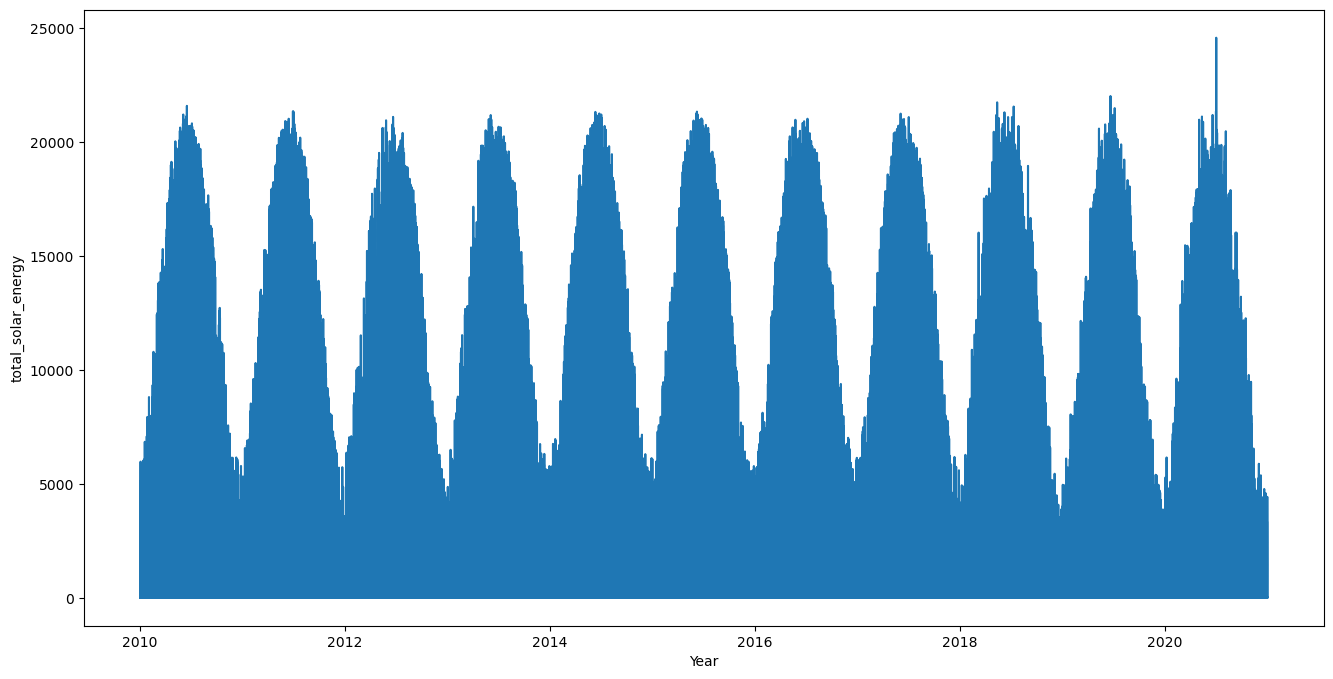

In [28]:
# Time series of our y variable . i.e total energy

plt.figure(figsize=(16,8))
plt.plot(train_data.index, train_data['total_energy'])
plt.xlabel('Year')
plt.ylabel('total_solar_energy')
_=plt.savefig('./total_solar_energy.pdf', dpi=500)

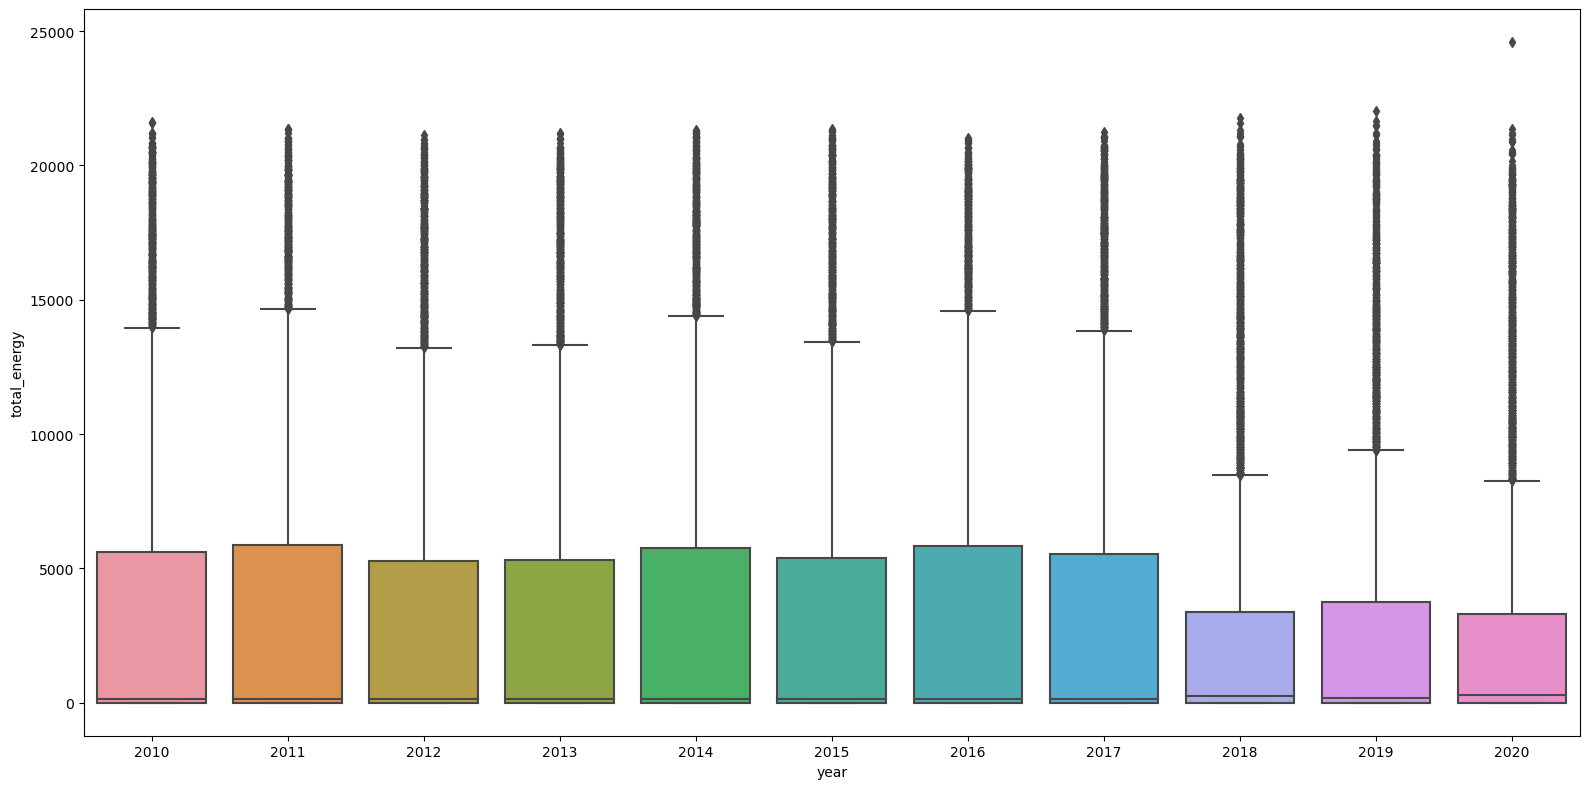

In [29]:
plt.figure(figsize=(16, 8))
_=sns.boxplot(x='year', y='total_energy', data=train_data)
_=plt.tight_layout()
_=plt.savefig('./boxplots_per_year.pdf', dpi=1000)

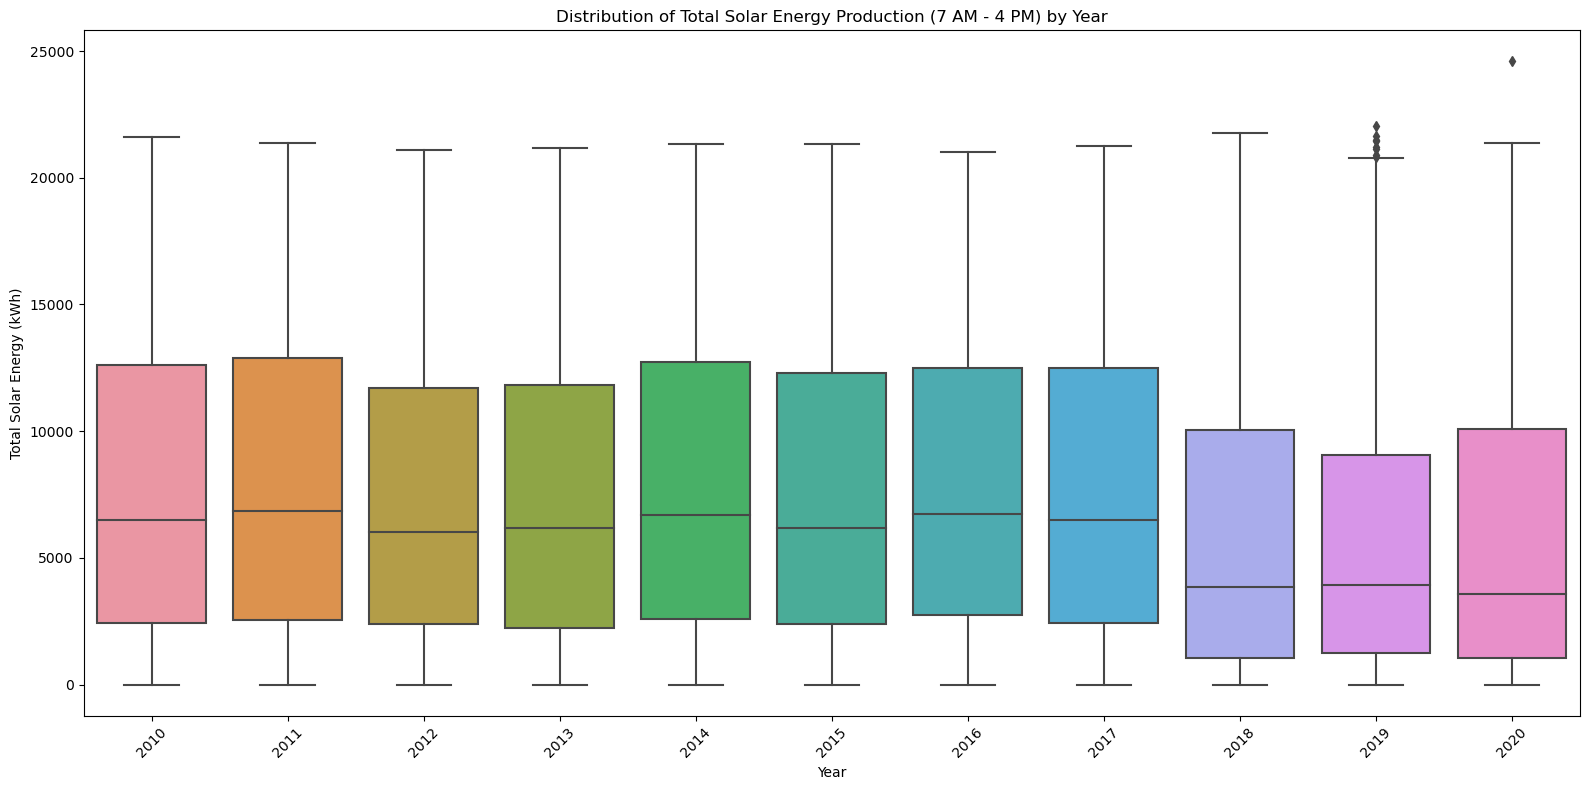

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

hourly_filtered = train_data.loc[(train_data['hour'] >= 7) & (train_data['hour'] <= 16)].copy()  
hourly_filtered['year'] = hourly_filtered.index.year 

plt.figure(figsize=(16,8))
sns.boxplot(data=hourly_filtered, x='year', y='total_energy')
plt.xlabel('Year')
plt.ylabel('Total Solar Energy (kWh)')
plt.title('Distribution of Total Solar Energy Production (7 AM - 4 PM) by Year')
plt.xticks(rotation=45) 
plt.tight_layout()  
plt.savefig('./filtered_solar_energy_boxplot_sns.pdf', dpi=500)
plt.show()


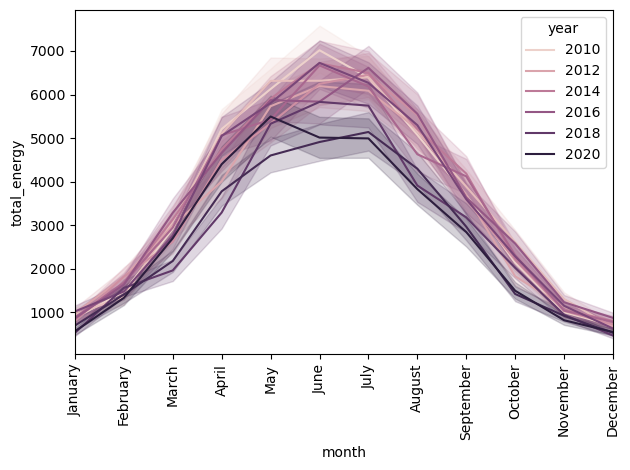

In [31]:
# Visualise trends across years
sns.lineplot(x='month', y='total_energy', data=train_data, hue='year')
_=plt.xticks(np.arange(1, 13), months_of_the_year, rotation=90)
_=plt.xlim(1, 12)  # limit x-axis
_=plt.tight_layout()
_=plt.savefig('./trend_lineplot.pdf', dpi=1000)

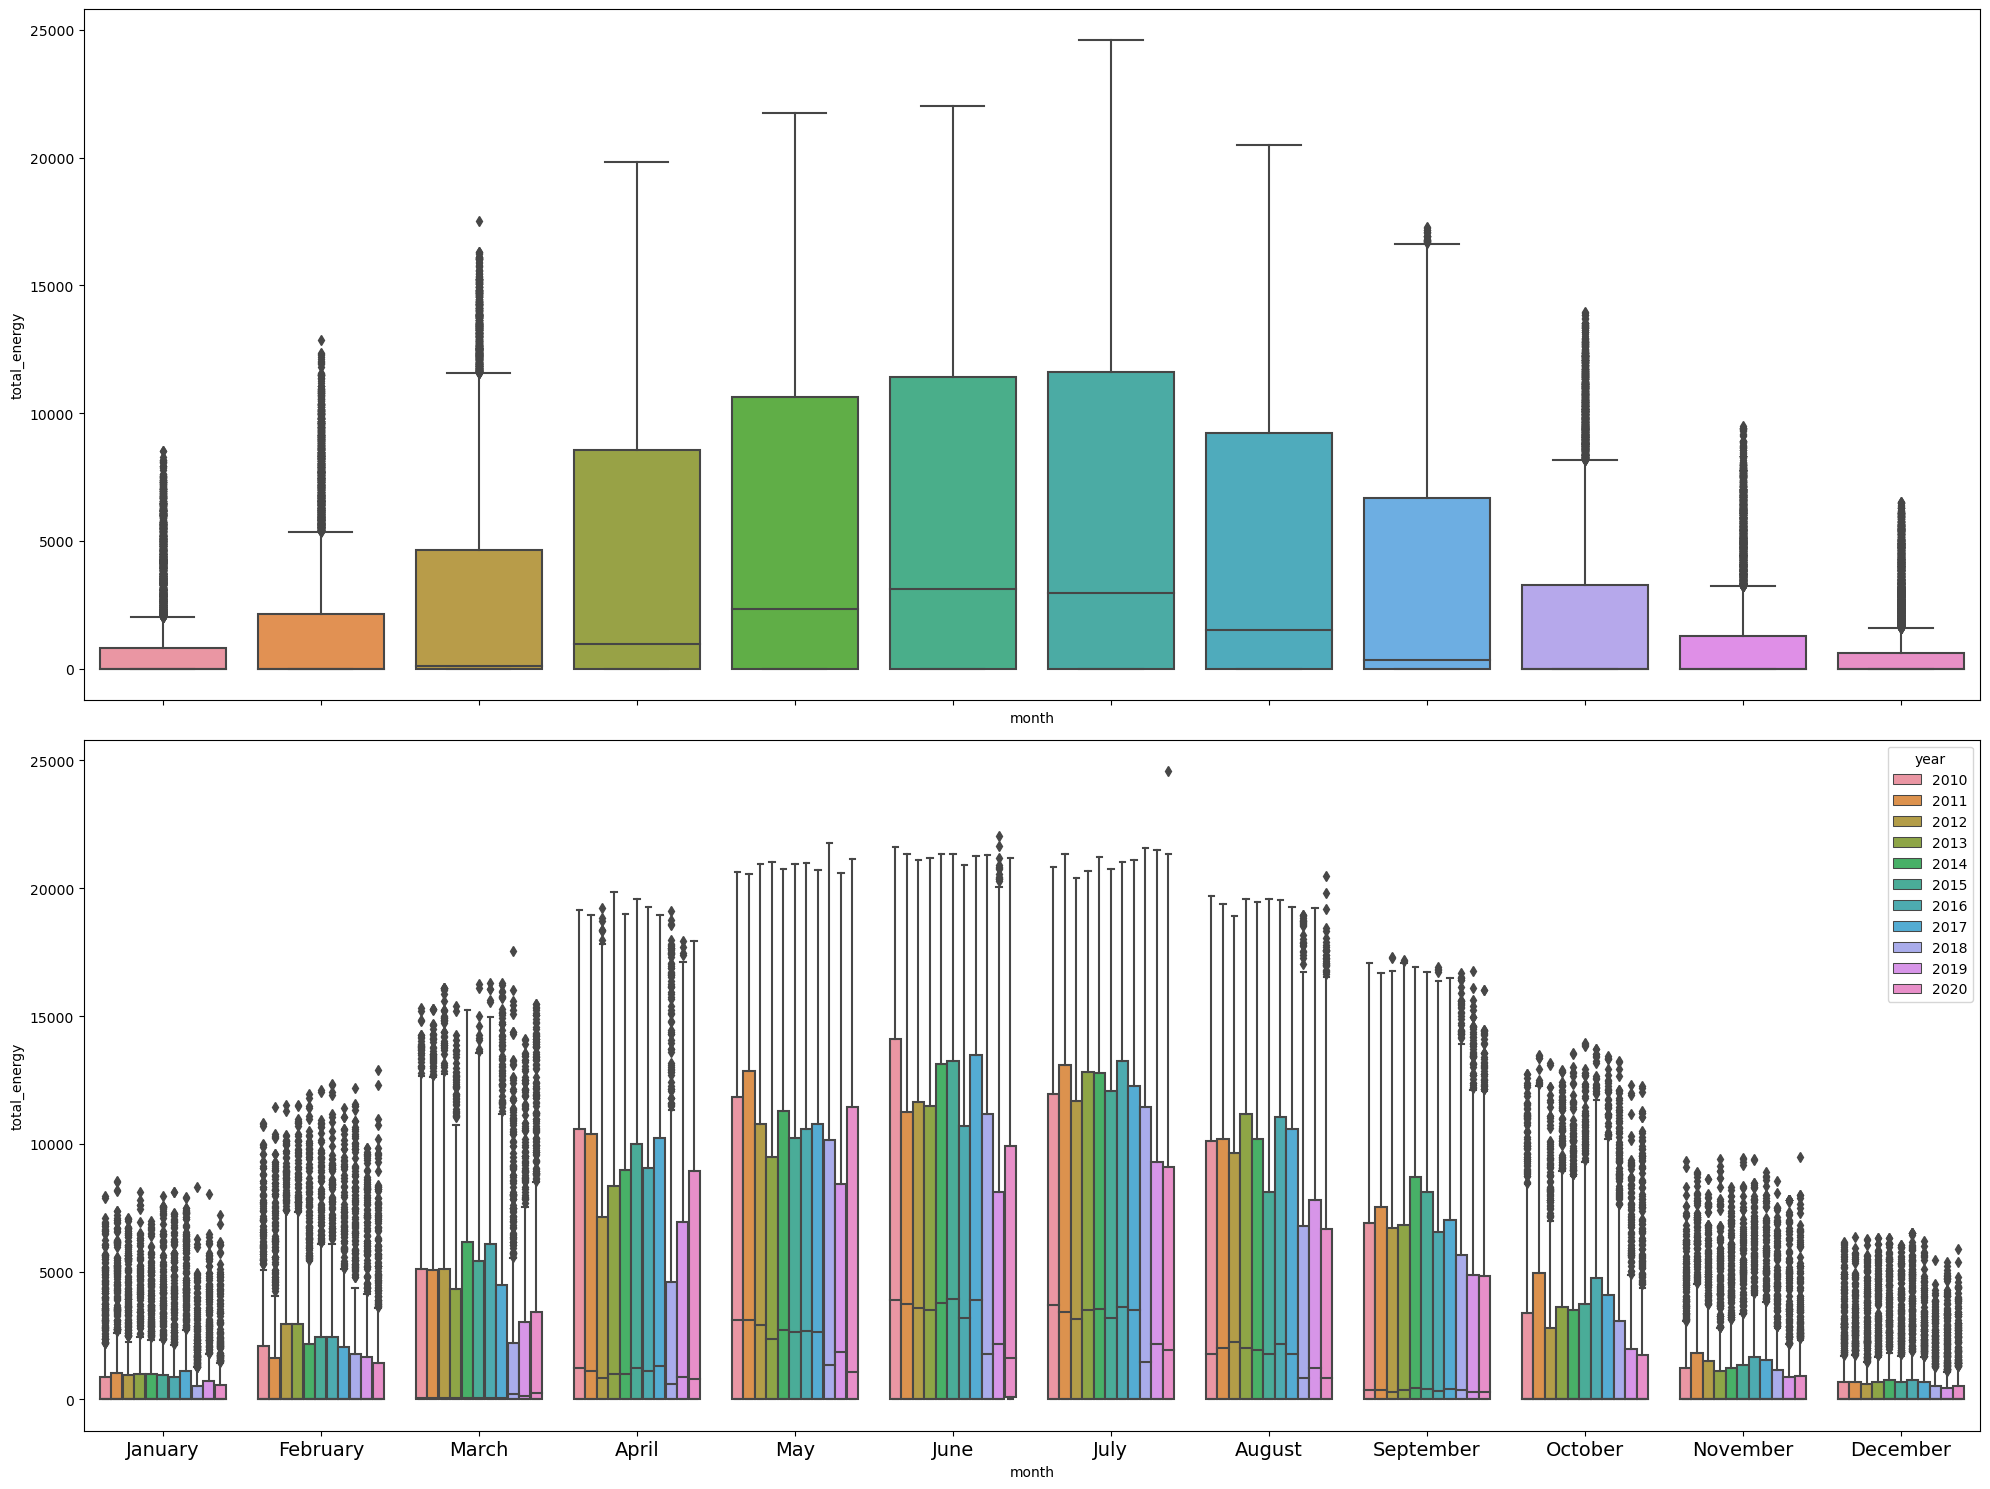

In [32]:
# Visualise trends across years
fix, ax = plt.subplots(2, 1, sharex=True, figsize=(20,15))
sns.boxplot(x='month', y='total_energy', data=train_data, ax=ax[0])  # top plot
sns.boxplot(x='month', y='total_energy', data=train_data, hue='year', ax=ax[1])  # bottom plot
ax[1].set_xticks(np.arange(0, 12), months_of_the_year, fontsize=14)
plt.tight_layout()
plt.savefig('./trend_boxplots.pdf', dpi=1000)

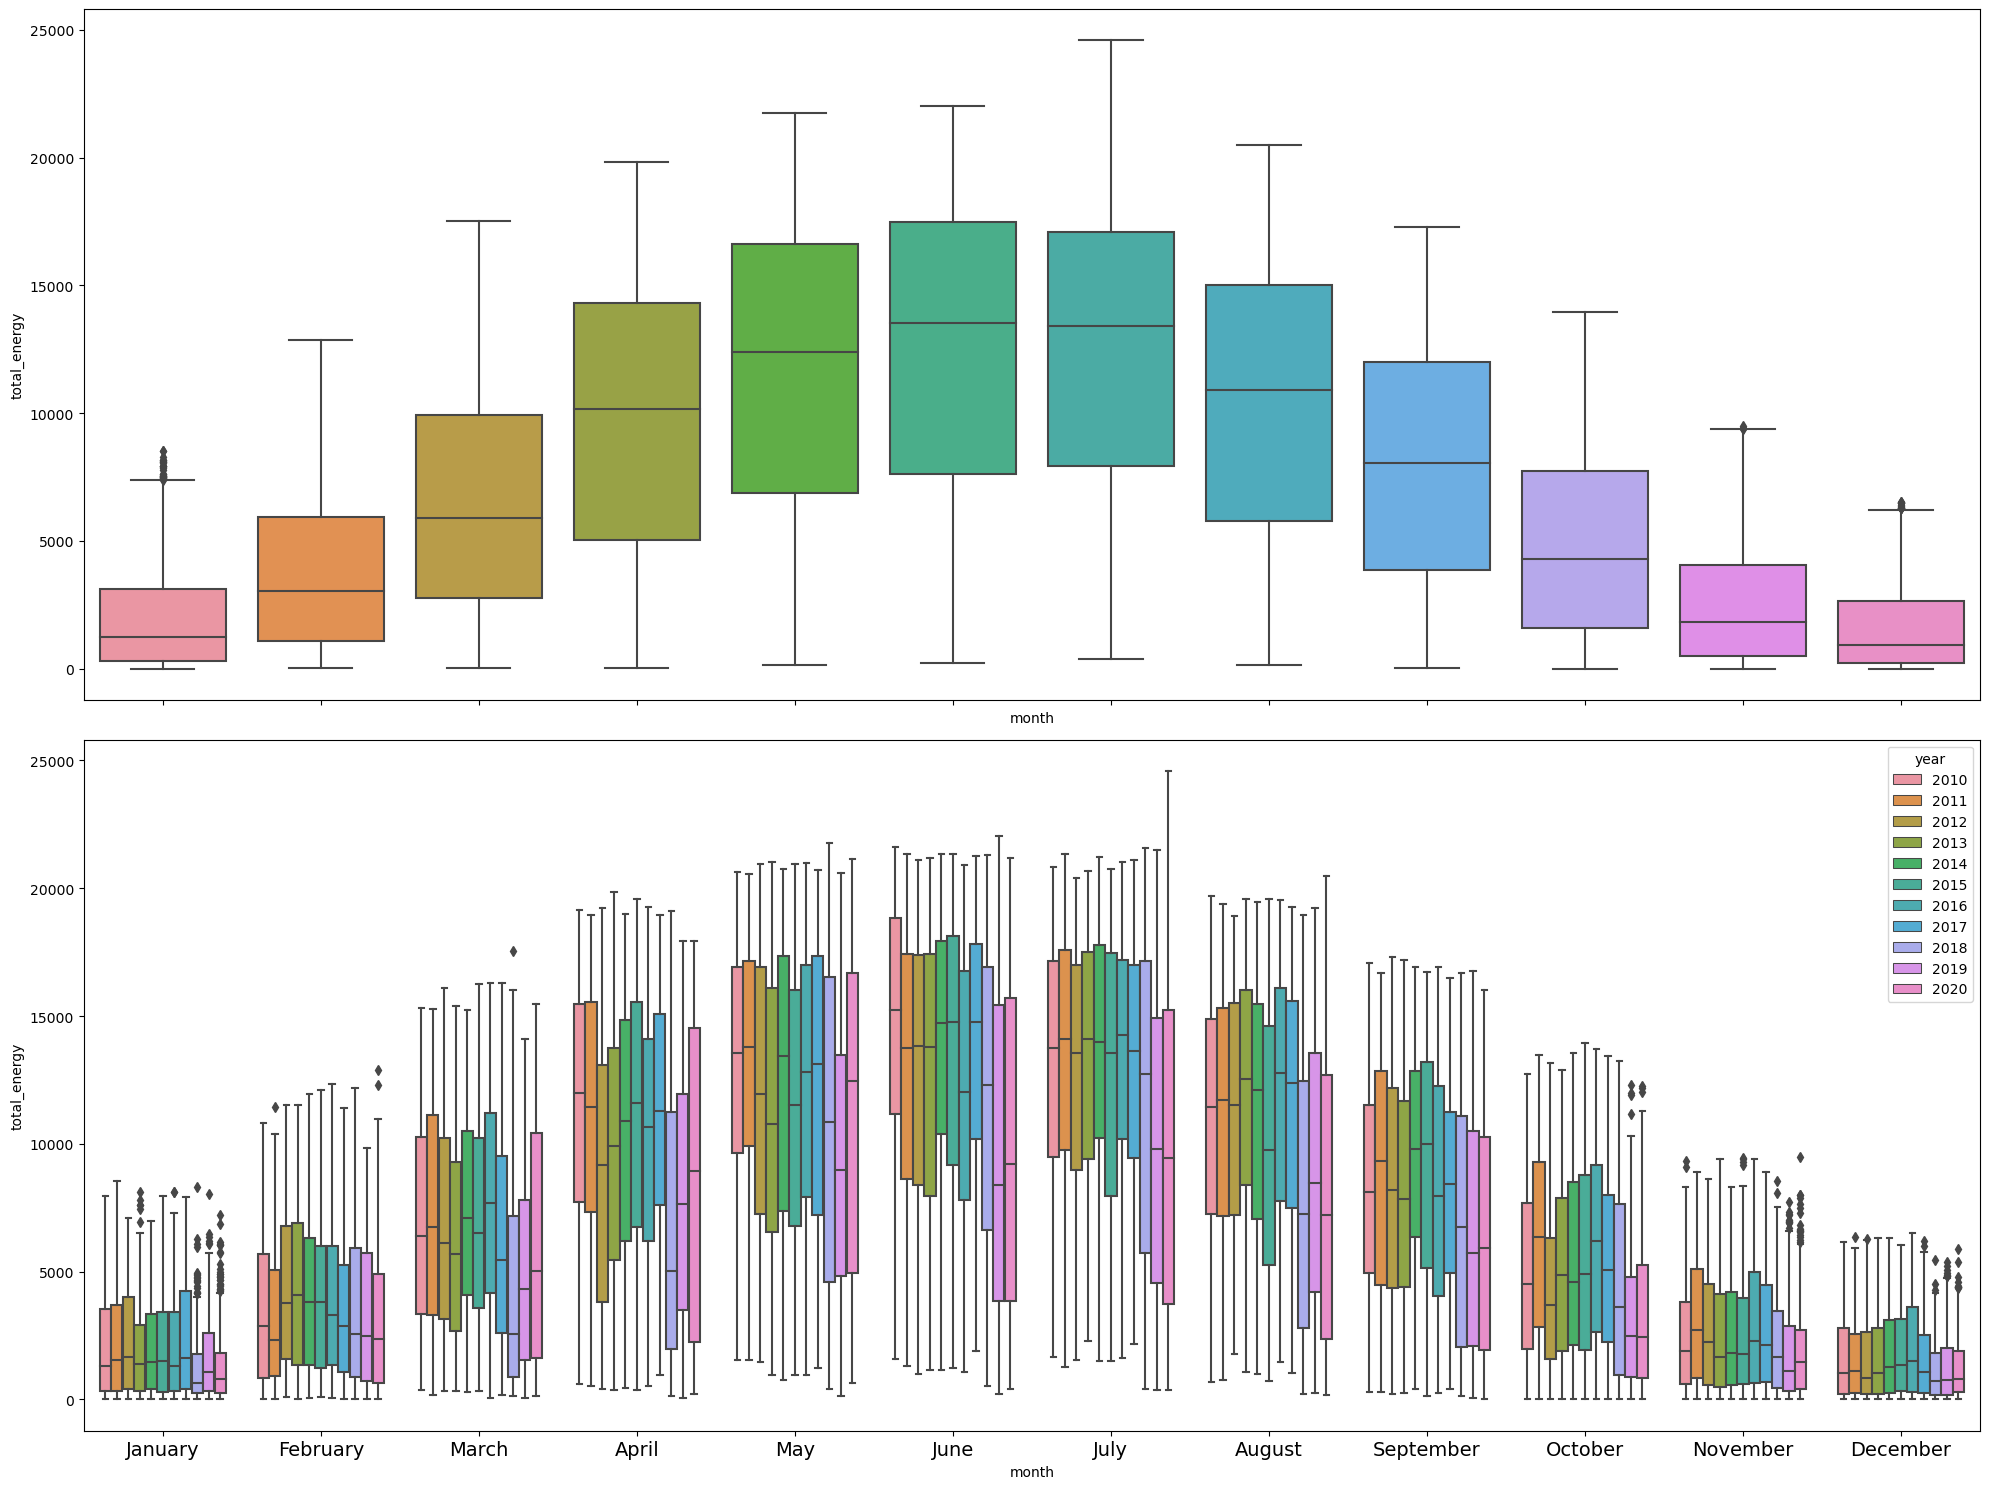

In [33]:
filtered_hours_data = train_data.between_time('07:00', '16:00')
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(20, 15))
sns.boxplot(x='month', y='total_energy', data=filtered_hours_data, ax=ax[0])
sns.boxplot(x='month', y='total_energy', data=filtered_hours_data, hue='year', ax=ax[1])
ax[1].set_xticks(np.arange(12))
ax[1].set_xticklabels(months_of_the_year, fontsize=14)
plt.tight_layout()
plt.savefig('./filtered_trend_boxplots.pdf', dpi=1000)
plt.show()

# Time Series decomposition

In [34]:
data_ds = train_data['total_energy'].resample('M').mean().ffill().to_frame()  # one value per month
data_ds

,total_energy
2010-01-31,873.340944
2010-02-28,1469.532297
2010-03-31,2914.398120
2010-04-30,5208.199218
2010-05-31,6126.723055
...,...
2020-08-31,3828.630464
2020-09-30,2842.546164
2020-10-31,1494.951287
2020-11-30,817.414797


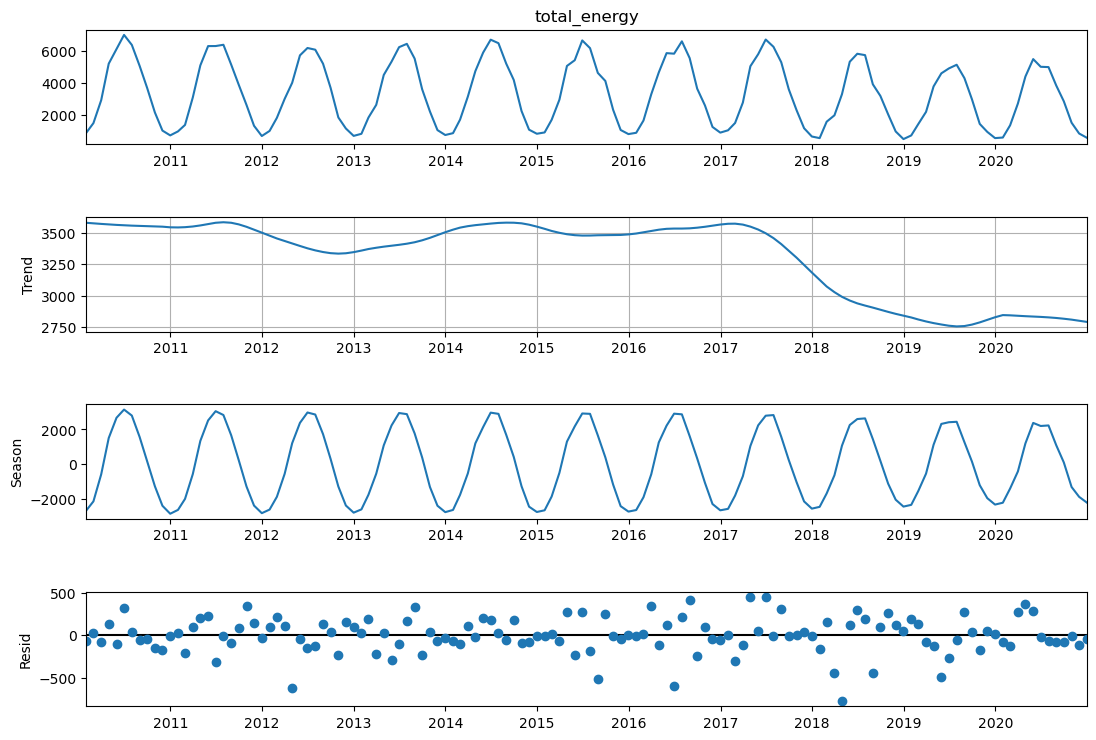

In [35]:
decomposition = STL(data_ds['total_energy']).fit()
fig = decomposition.plot()
fig.set_size_inches(12,8)
fig.axes[1].grid()
plt.savefig('./avg_temp_decomp.pdf', dpi=1000)

In [36]:
# Statistical test for stationarity: Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(data_ds['total_energy'])
print('ADF Statistic %.2f:' % adf_result[0])
print('ADF p-value: %.4f:' % adf_result[1])

ADF Statistic -0.52:
ADF p-value: 0.8874:


result shows a high p-value (greater than 0.05) and adf statistic is not negative enough, so it indicates that the data is likely non-stationary. 

Correaltion: 

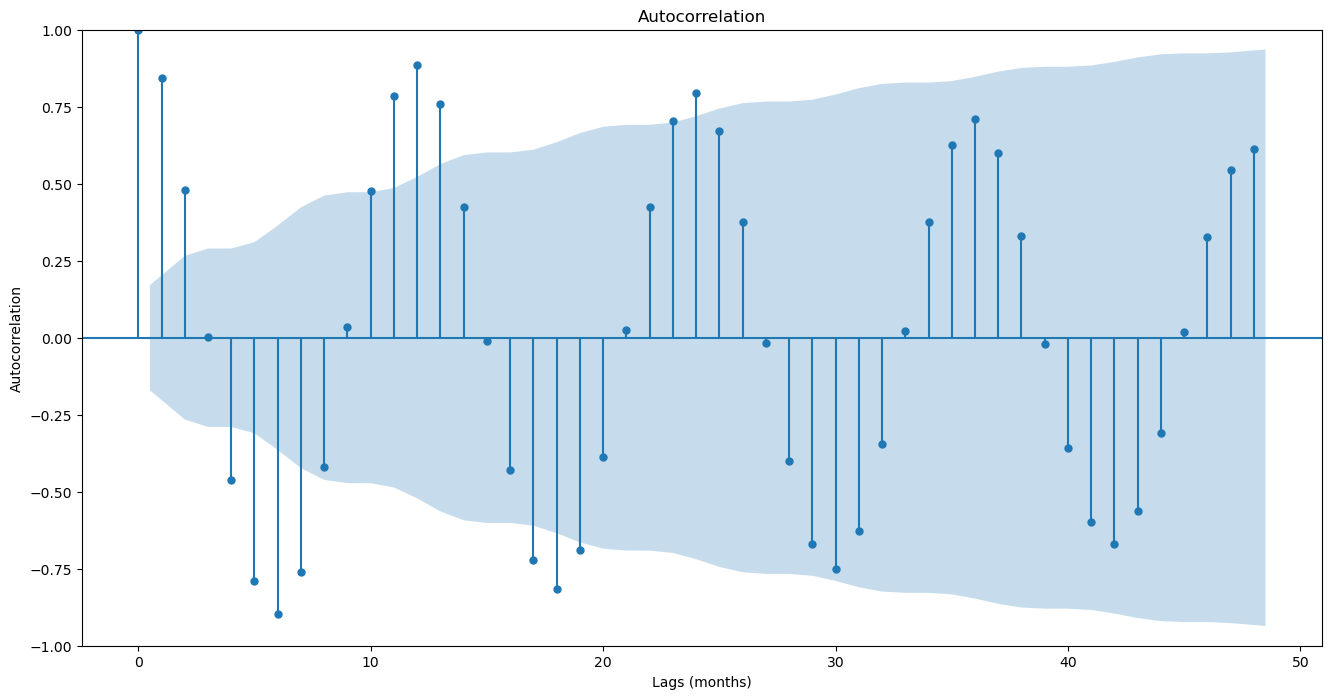

In [37]:
# Autocorrelation (can help us with modelling later)
fig, ax = plt.subplots(figsize=(16,8))
_=plot_acf(data_ds['total_energy'], lags=48, ax=ax)  # each lag is one month, so we're looking at 4 years worth of past data
_=plt.xlabel('Lags (months)')
_=plt.ylabel('Autocorrelation')
_=plt.savefig('autocorrelation_orig.pdf', dpi=500)

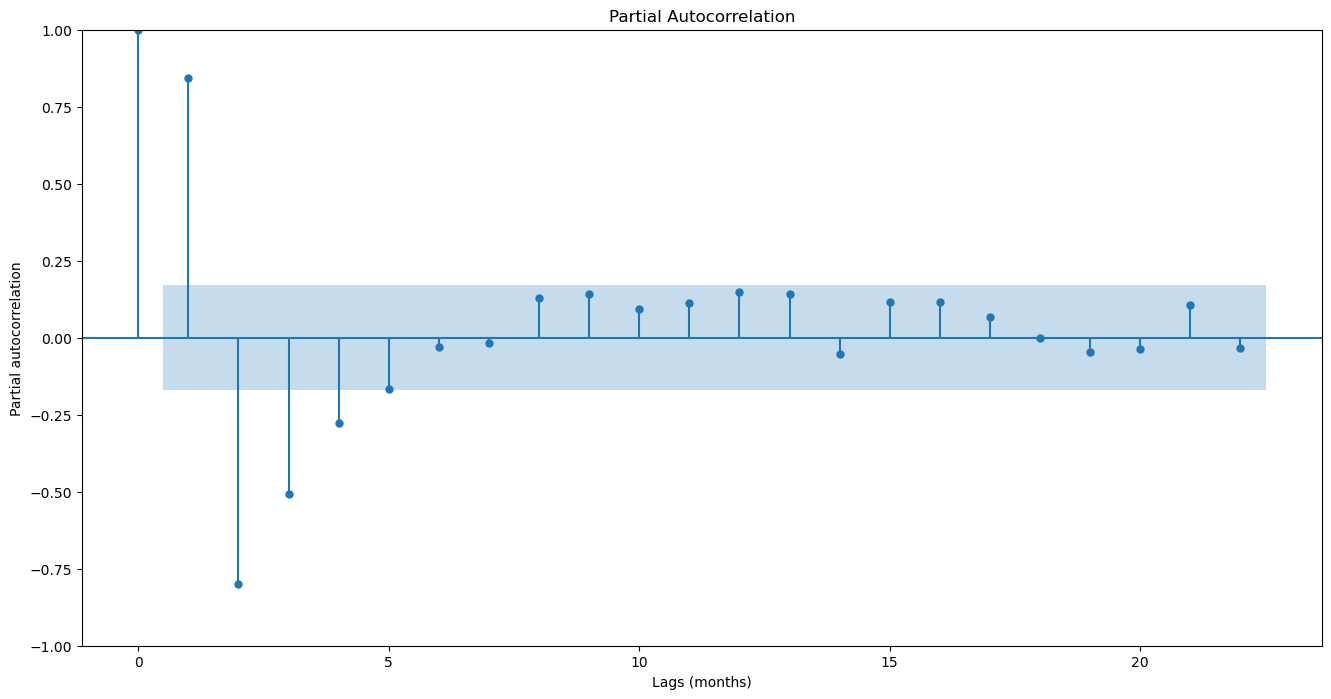

In [38]:
fig, ax = plt.subplots(figsize=(16,8))
_ = plot_pacf(data_ds['total_energy'], ax=ax, method='ywm')
_ = plt.xlabel('Lags (months)')
_ = plt.ylabel('Partial autocorrelation')
_ = plt.savefig('partial_autocorrelation_orig.pdf', dpi=500)


In [39]:
data= train_data.copy()

In [40]:
time_columns = ['date', 'year', 'month', 'day', 'time', 'hour', 'day_of_week', 'week_of_year', 'day_of_year', 'season']

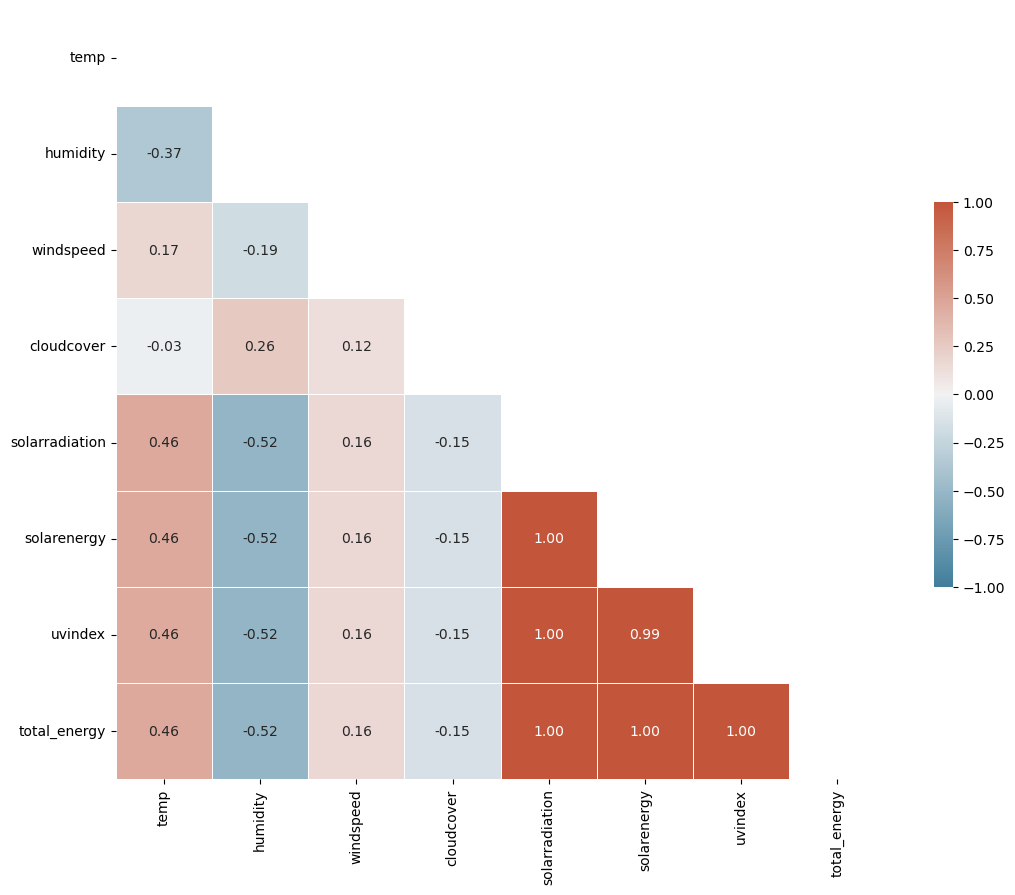

In [41]:
data_without_time = data.drop(columns=time_columns)
corr = data_without_time.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, fmt='.2f')
plt.tight_layout()
plt.savefig('./correlations.pdf', dpi=1000)
plt.show()

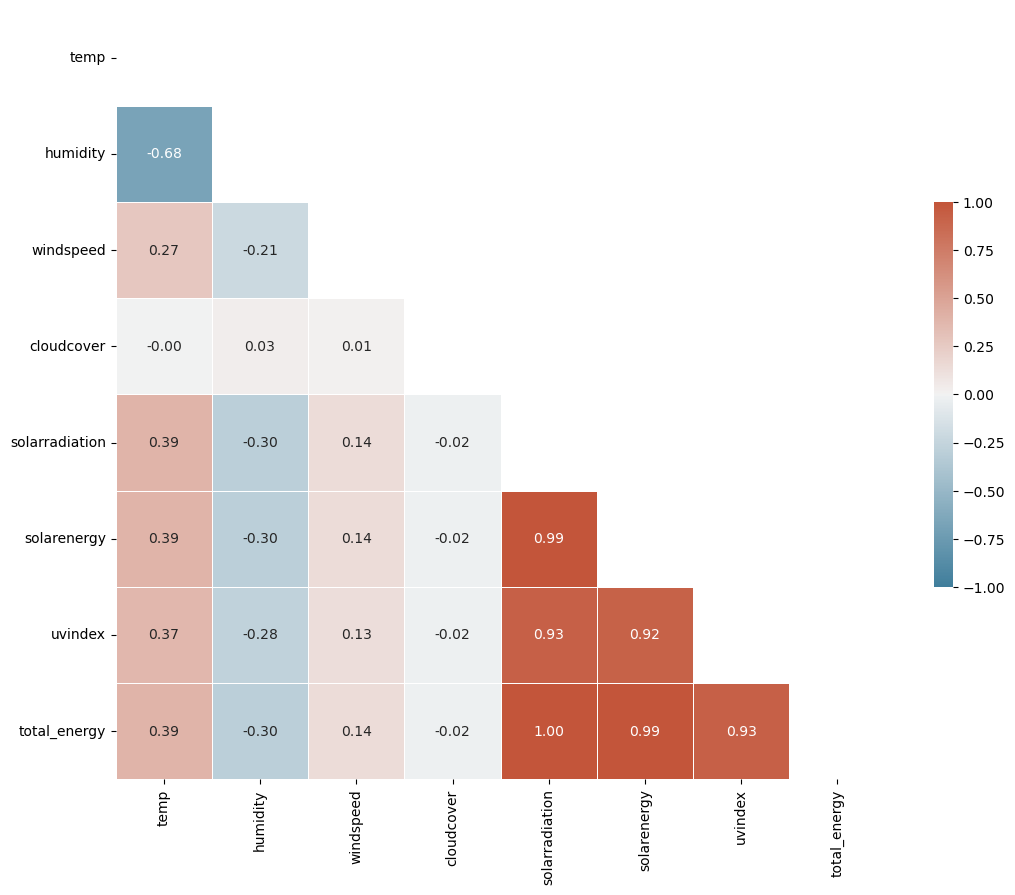

In [42]:
data_without_time = data.drop(columns=time_columns)
corr_diff = data_without_time.diff().corr()
mask = np.triu(np.ones_like(corr_diff, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_diff, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, fmt='.2f')
plt.tight_layout()
plt.savefig('./correlations_diff.pdf', dpi=1000)
plt.show()

In [43]:
data= train_data.copy()
data_without_time = data.drop(columns=time_columns)
data_without_time['total_energy_lag24'] = data_without_time['total_energy'].shift(-24)
data_without_time.head(50)

,temp,humidity,windspeed,cloudcover,solarradiation,solarenergy,uvindex,total_energy,total_energy_lag24
2010-01-01 00:00:00,1.9,84.25,19.4,62.2,0.0,0.0,0.0,0.000000,0.000000
2010-01-01 01:00:00,1.9,83.90,21.8,22.4,0.0,0.0,0.0,0.000000,0.000000
2010-01-01 02:00:00,1.4,85.76,17.7,38.0,0.0,0.0,0.0,0.000000,0.000000
2010-01-01 03:00:00,1.4,85.69,18.0,66.7,0.0,0.0,0.0,0.000000,0.000000
2010-01-01 04:00:00,1.3,85.72,17.4,62.8,0.0,0.0,0.0,0.000000,0.000000
2010-01-01 05:00:00,0.6,89.01,15.9,26.3,0.0,0.0,0.0,0.000000,0.000000
2010-01-01 06:00:00,0.9,89.16,15.4,10.0,0.0,0.0,0.0,0.000000,0.000000
2010-01-01 07:00:00,0.2,87.99,12.6,10.0,0.0,0.0,0.0,0.000000,0.000000
2010-01-01 08:00:00,-0.5,88.55,14.3,32.7,23.6,0.1,0.0,544.383607,664.332538
2010-01-01 09:00:00,-0.6,85.40,14.2,37.8,93.0,0.3,1.0,2145.240486,2551.221481


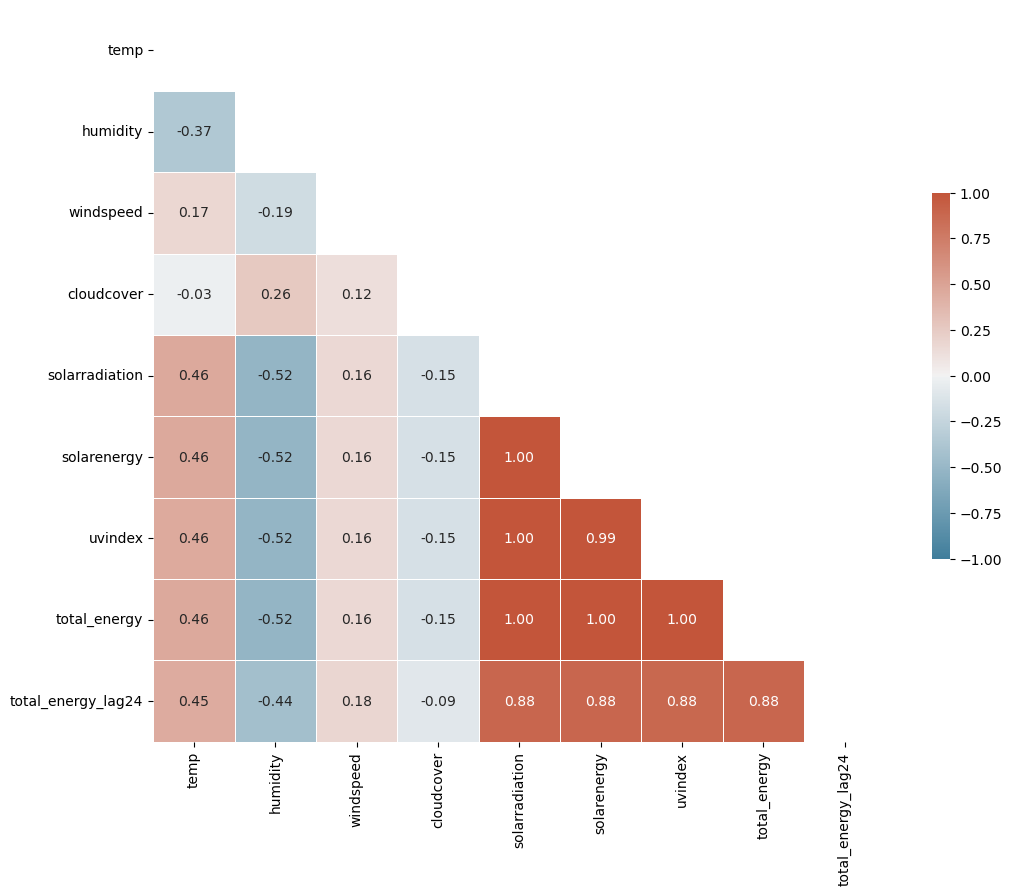

In [44]:
data= train_data.copy()
data_without_time = data.drop(columns=time_columns)
data_without_time['total_energy_lag24'] = data_without_time['total_energy'].shift(-24)
corr = data_without_time.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, fmt='.2f')
plt.tight_layout()
plt.savefig('./correlations_lagged.pdf', dpi=1000)
plt.show()

                    total_energy_lag24  solarradiation
total_energy_lag24            1.000000        0.676919
solarradiation                0.676919        1.000000


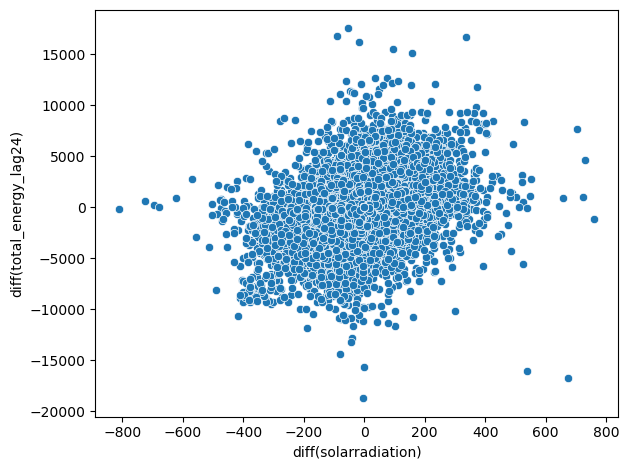

In [45]:
# Let's add a lag to one of them
_=sns.scatterplot(x='solarradiation', y='total_energy_lag24', data=data_without_time.diff())
plt.ylabel('diff(total_energy_lag24)')
plt.xlabel('diff(solarradiation)')
print(data_without_time[['total_energy_lag24', 'solarradiation']].diff().corr())  # this correlation is .27
plt.tight_layout()
_=plt.savefig('./timeseries_correlations_lag_diff.pdf', dpi=1000)

Making the target variable 

In [46]:
train_data.columns

Index(['temp', 'humidity', 'windspeed', 'cloudcover', 'solarradiation',
       'solarenergy', 'uvindex', 'date', 'year', 'month', 'day', 'time',
       'hour', 'day_of_week', 'week_of_year', 'day_of_year', 'season',
       'total_energy'],
      dtype='object')

In [47]:
train_data.loc[:, 'total_energy_forecast'] = train_data['total_energy'].shift(-24)
val_data.loc[:, 'total_energy_forecast'] = val_data['total_energy'].shift(-24)
test_data.loc[:, 'total_energy_forecast'] = test_data['total_energy'].shift(-24)
train_data.dropna(inplace=True)
val_data.dropna(inplace=True)
test_data.dropna(inplace=True)

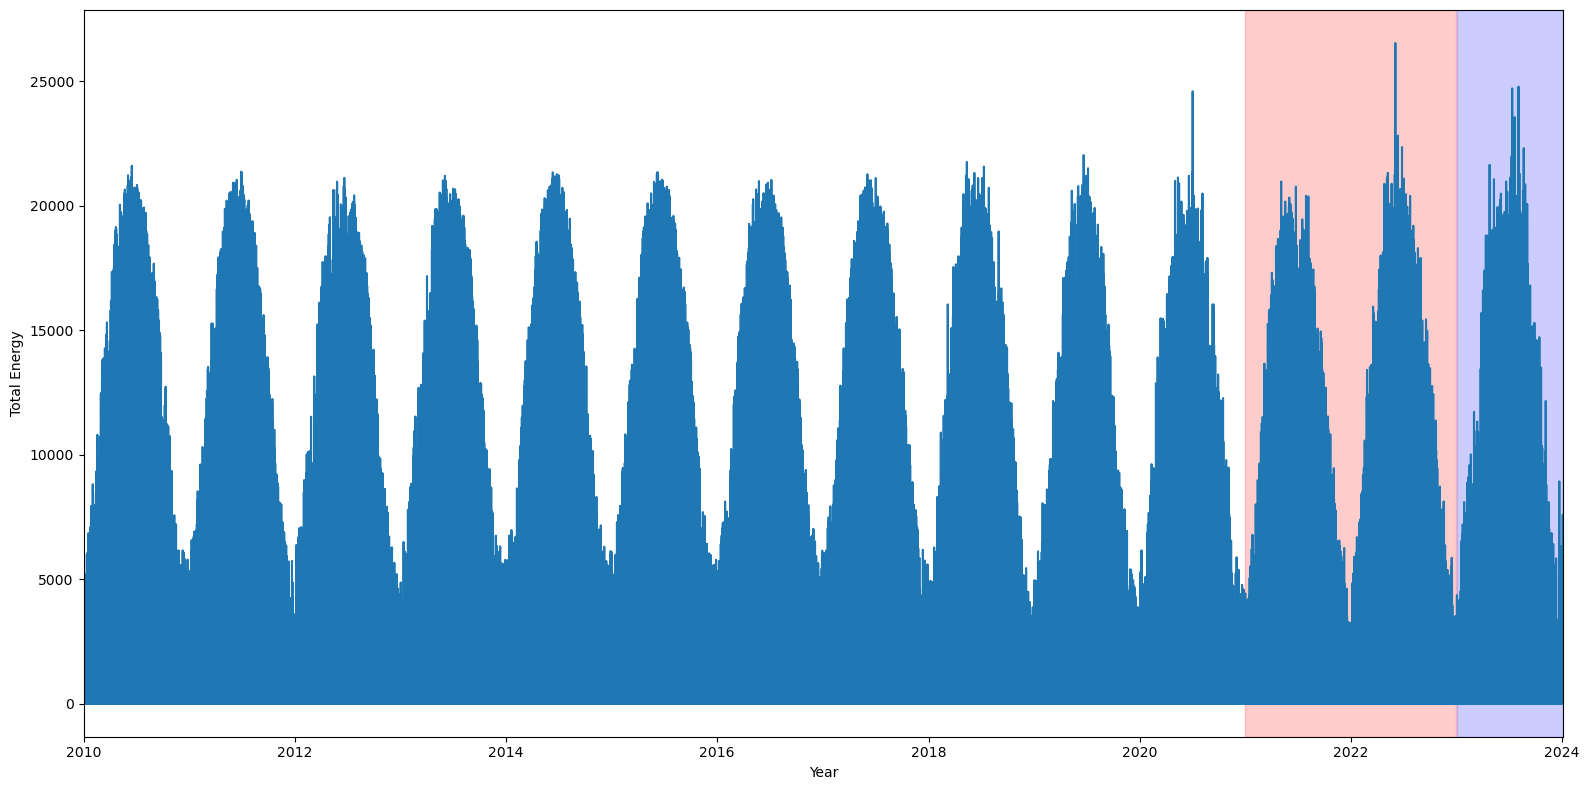

In [48]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(df_reindexed.index, df_reindexed['total_energy'])
ax.axvspan(val_data.index.min(), val_data.index.max(), alpha=.2, color='red')  # validation set
ax.axvspan(test_data.index.min(), test_data.index.max(), alpha=.2, color='blue')  # test set
ax.set_xlabel('Year')
ax.set_ylabel('Total Energy')
_=ax.set_xlim(train_data.index.min(), test_data.index.max())
plt.tight_layout()
plt.savefig('./train-val-test-sets.pdf', dpi=1000)

In [49]:
train_data.head(10)

,temp,humidity,windspeed,cloudcover,solarradiation,solarenergy,uvindex,date,year,month,day,time,hour,day_of_week,week_of_year,day_of_year,season,total_energy,total_energy_forecast
2010-01-01 00:00:00,1.9,84.25,19.4,62.2,0.0,0.0,0.0,2010-01-01,2010,1,1,00:00:00,0,4,53,1,1,0.000000,0.000000
2010-01-01 01:00:00,1.9,83.90,21.8,22.4,0.0,0.0,0.0,2010-01-01,2010,1,1,01:00:00,1,4,53,1,1,0.000000,0.000000
2010-01-01 02:00:00,1.4,85.76,17.7,38.0,0.0,0.0,0.0,2010-01-01,2010,1,1,02:00:00,2,4,53,1,1,0.000000,0.000000
2010-01-01 03:00:00,1.4,85.69,18.0,66.7,0.0,0.0,0.0,2010-01-01,2010,1,1,03:00:00,3,4,53,1,1,0.000000,0.000000
2010-01-01 04:00:00,1.3,85.72,17.4,62.8,0.0,0.0,0.0,2010-01-01,2010,1,1,04:00:00,4,4,53,1,1,0.000000,0.000000
2010-01-01 05:00:00,0.6,89.01,15.9,26.3,0.0,0.0,0.0,2010-01-01,2010,1,1,05:00:00,5,4,53,1,1,0.000000,0.000000
2010-01-01 06:00:00,0.9,89.16,15.4,10.0,0.0,0.0,0.0,2010-01-01,2010,1,1,06:00:00,6,4,53,1,1,0.000000,0.000000
2010-01-01 07:00:00,0.2,87.99,12.6,10.0,0.0,0.0,0.0,2010-01-01,2010,1,1,07:00:00,7,4,53,1,1,0.000000,0.000000
2010-01-01 08:00:00,-0.5,88.55,14.3,32.7,23.6,0.1,0.0,2010-01-01,2010,1,1,08:00:00,8,4,53,1,1,544.383607,664.332538
2010-01-01 09:00:00,-0.6,85.40,14.2,37.8,93.0,0.3,1.0,2010-01-01,2010,1,1,09:00:00,9,4,53,1,1,2145.240486,2551.221481


# Baseline Model

Validation Set Metrics:
MAE: 2718.953169803292
MSE: 27886763.85255389
RMSE: 5280.791972096031
R-squared: -0.30371106391270053

Test Set Metrics:
MAE: 2746.6764133405954
MSE: 29143335.858487196
RMSE: 5398.456803428846
R-squared: -0.28981280884907057


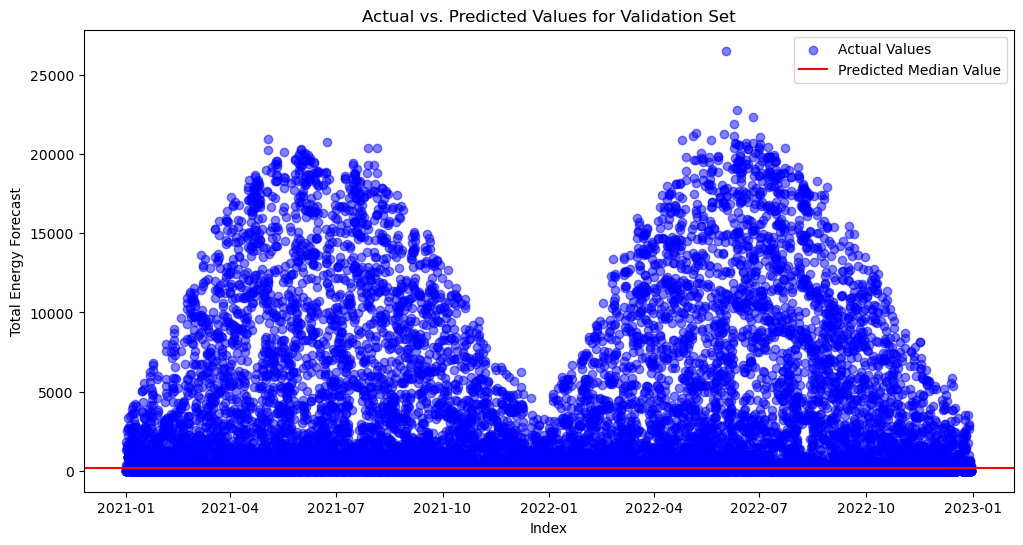

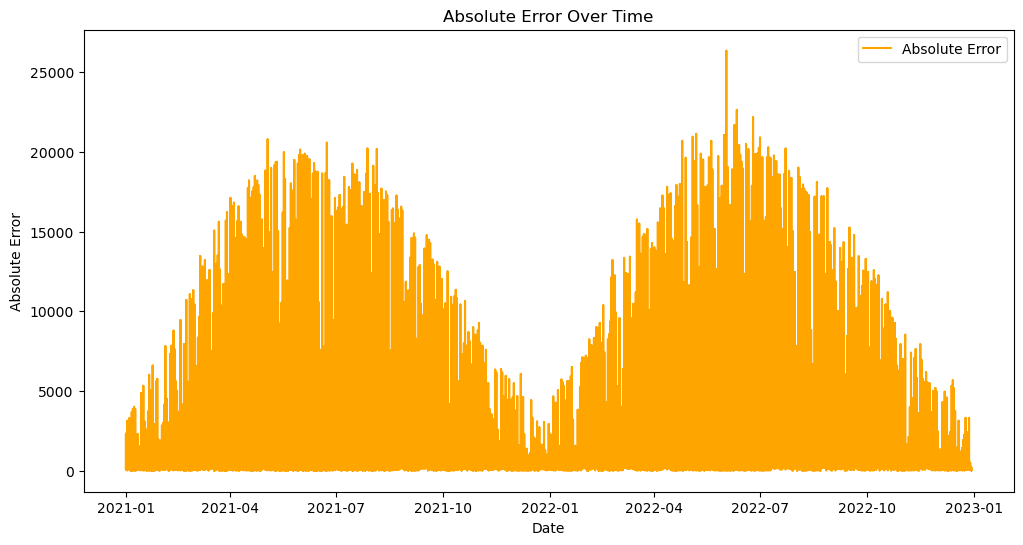

In [50]:
# Baseline model: Predict the median or mean value of total_energy_forecast
median_prediction = np.median(train_data['total_energy_forecast'])  # Or use np.mean() for mean prediction

# Create predictions for validation and test sets
val_predictions = np.full_like(val_data['total_energy_forecast'], median_prediction)
test_predictions = np.full_like(test_data['total_energy_forecast'], median_prediction)

# Evaluate the baseline model
val_mae = mean_absolute_error(val_data['total_energy_forecast'], val_predictions)
val_mse = mean_squared_error(val_data['total_energy_forecast'], val_predictions)
val_r2 = r2_score(val_data['total_energy_forecast'], val_predictions)
val_rmse = np.sqrt(val_mse)

test_mae = mean_absolute_error(test_data['total_energy_forecast'], test_predictions)
test_mse = mean_squared_error(test_data['total_energy_forecast'], test_predictions)
test_r2 = r2_score(test_data['total_energy_forecast'], test_predictions)
test_rmse = np.sqrt(test_mse)

# Print evaluation metrics
print("Validation Set Metrics:")
print("MAE:", val_mae)
print("MSE:", val_mse)
print("RMSE:", val_rmse)
print("R-squared:", val_r2)

print("\nTest Set Metrics:")
print("MAE:", test_mae)
print("MSE:", test_mse)
print("RMSE:", test_rmse)
print("R-squared:", test_r2)

# Scatter Plot of Actual vs. Predicted Values
plt.figure(figsize=(12, 6))
plt.scatter(val_data.index, val_data['total_energy_forecast'], color='blue', label='Actual Values', alpha=0.5)
plt.axhline(y=median_prediction, color='r', linestyle='-', label='Predicted Median Value')
plt.title('Actual vs. Predicted Values for Validation Set')
plt.xlabel('Index')
plt.ylabel('Total Energy Forecast')
plt.legend()
plt.show()

# Assuming there's a temporal component, plot the Error Metrics
# For demonstration, assume val_data has a 'date' column. Adjust according to your dataset.
if 'date' in val_data.columns:
    plt.figure(figsize=(12, 6))
    plt.plot(val_data['date'], np.abs(val_data['total_energy_forecast'] - median_prediction), label='Absolute Error', color='orange')
    plt.title('Absolute Error Over Time')
    plt.xlabel('Date')
    plt.ylabel('Absolute Error')
    plt.legend()
    plt.show()

# Machine learning

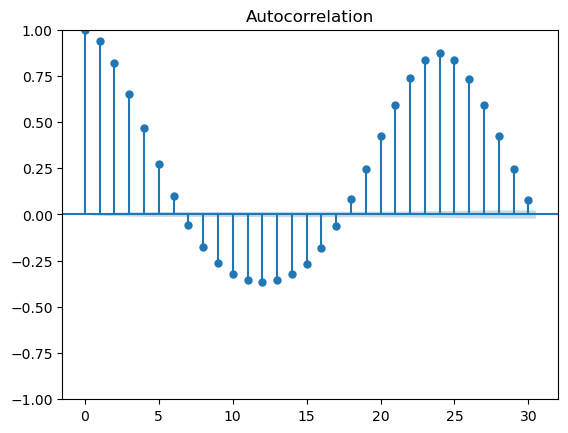

In [51]:
_=plot_acf(df_reindexed['total_energy'], lags=30)  

C:\Users\mrudu\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


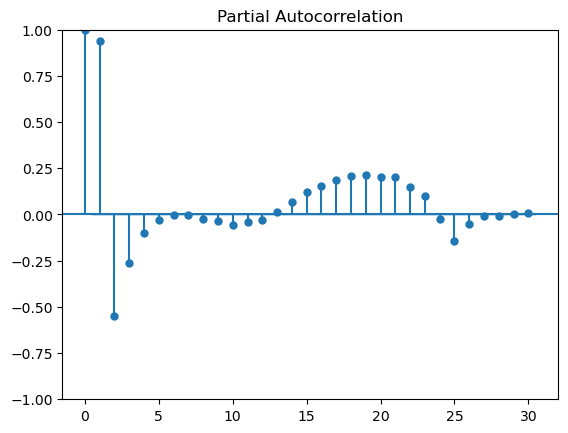

In [52]:
# Plot the PACF
_=plot_pacf(df_reindexed['total_energy'], lags=30)

In [53]:
df_reindexed.head()

,temp,humidity,windspeed,cloudcover,solarradiation,solarenergy,uvindex,date,year,month,day,time,hour,day_of_week,week_of_year,day_of_year,season,total_energy
2010-01-01 00:00:00,1.9,84.25,19.4,62.2,0.0,0.0,0.0,2010-01-01,2010,1,1,00:00:00,0,4,53,1,1,0.0
2010-01-01 01:00:00,1.9,83.90,21.8,22.4,0.0,0.0,0.0,2010-01-01,2010,1,1,01:00:00,1,4,53,1,1,0.0
2010-01-01 02:00:00,1.4,85.76,17.7,38.0,0.0,0.0,0.0,2010-01-01,2010,1,1,02:00:00,2,4,53,1,1,0.0
2010-01-01 03:00:00,1.4,85.69,18.0,66.7,0.0,0.0,0.0,2010-01-01,2010,1,1,03:00:00,3,4,53,1,1,0.0
2010-01-01 04:00:00,1.3,85.72,17.4,62.8,0.0,0.0,0.0,2010-01-01,2010,1,1,04:00:00,4,4,53,1,1,0.0


In [136]:
# Prepare data for ML: create windows

total_energy_df = df_reindexed['total_energy'].copy().to_frame()  # one value per day
# We want to forecast one month at a time. Let's create windows of the last year (so 12 columns)
forecast_horizon = 24  # next month
window_size = 12  # use one year of data
for lag in range(window_size-1):
    total_energy_df['total_energy_lag%d' % (lag+1)] = total_energy_df['total_energy'].shift(lag+1)
total_energy_df['y'] = total_energy_df['total_energy'].shift(-forecast_horizon)  # our target
total_energy_df.head(10)

,total_energy,total_energy_lag1,total_energy_lag2,total_energy_lag3,total_energy_lag4,total_energy_lag5,total_energy_lag6,total_energy_lag7,total_energy_lag8,total_energy_lag9,total_energy_lag10,total_energy_lag11,y
2010-01-01 00:00:00,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2010-01-01 01:00:00,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2010-01-01 02:00:00,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2010-01-01 03:00:00,0.000000,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2010-01-01 04:00:00,0.000000,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2010-01-01 05:00:00,0.000000,0.000000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2010-01-01 06:00:00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.000000
2010-01-01 07:00:00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.000000
2010-01-01 08:00:00,544.383607,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,664.332538
2010-01-01 09:00:00,2145.240486,544.383607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,2551.221481


In [55]:
total_energy_df.dropna(inplace=True)
total_energy_df

,total_energy,total_energy_lag1,total_energy_lag2,total_energy_lag3,total_energy_lag4,total_energy_lag5,total_energy_lag6,total_energy_lag7,total_energy_lag8,total_energy_lag9,total_energy_lag10,total_energy_lag11,y
2010-01-01 11:00:00,4230.506507,3169.419815,2145.240486,544.383607,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,5702.187614
2010-01-01 12:00:00,4147.464940,4230.506507,3169.419815,2145.240486,544.383607,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,5974.379418
2010-01-01 13:00:00,3589.241071,4147.464940,4230.506507,3169.419815,2145.240486,544.383607,0.000000,0.000000,0.0,0.0,0.0,0.0,4996.334293
2010-01-01 14:00:00,2154.467327,3589.241071,4147.464940,4230.506507,3169.419815,2145.240486,544.383607,0.000000,0.0,0.0,0.0,0.0,3019.483652
2010-01-01 15:00:00,548.997028,2154.467327,3589.241071,4147.464940,4230.506507,3169.419815,2145.240486,544.383607,0.0,0.0,0.0,0.0,772.747917
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-05 07:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
2024-01-05 08:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
2024-01-05 09:00:00,761.214366,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,530.543346
2024-01-05 10:00:00,1614.697140,761.214366,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1660.831344


In [ ]:
# # Splitting the dataset into train, validation, and test sets
# train_data = df_reindexed['2010':'2020']
# val_data = df_reindexed['2021':'2022']
# test_data = df_reindexed['2023':]

# # Display the starting and ending dates of each dataset 
# train_data.index.min(), train_data.index.max(), val_data.index.min(), val_data.index.max(), test_data.index.min(), test_data.index.max()

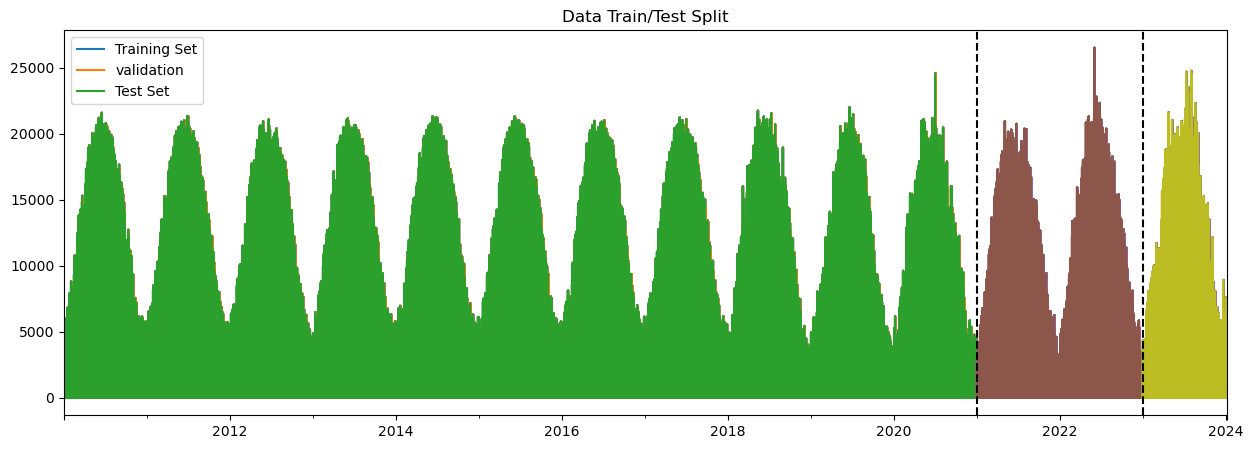

In [84]:
train = total_energy_df['2010':'2020']
val = total_energy_df['2021':'2022']
test = total_energy_df['2023':]


fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
val.plot(ax=ax, label='validation Set')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2021', color='black', ls='--')
ax.axvline('01-01-2023', color='black', ls='--')
ax.legend(['Training Set','validation', 'Test Set'])
plt.show()

In [85]:
train.index.min(), train.index.max(), val.index.min(), val.index.max(), test.index.min(), test.index.max()

(Timestamp('2010-01-01 11:00:00', freq='H'),
 Timestamp('2020-12-31 23:00:00', freq='H'),
 Timestamp('2021-01-01 00:00:00', freq='H'),
 Timestamp('2022-12-31 23:00:00', freq='H'),
 Timestamp('2023-01-01 00:00:00', freq='H'),
 Timestamp('2024-01-05 11:00:00', freq='H'))

In [86]:
train.head()

,total_energy,total_energy_lag1,total_energy_lag2,total_energy_lag3,total_energy_lag4,total_energy_lag5,total_energy_lag6,total_energy_lag7,total_energy_lag8,total_energy_lag9,total_energy_lag10,total_energy_lag11,y
2010-01-01 11:00:00,4230.506507,3169.419815,2145.240486,544.383607,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,5702.187614
2010-01-01 12:00:00,4147.464940,4230.506507,3169.419815,2145.240486,544.383607,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,5974.379418
2010-01-01 13:00:00,3589.241071,4147.464940,4230.506507,3169.419815,2145.240486,544.383607,0.000000,0.000000,0.0,0.0,0.0,0.0,4996.334293
2010-01-01 14:00:00,2154.467327,3589.241071,4147.464940,4230.506507,3169.419815,2145.240486,544.383607,0.000000,0.0,0.0,0.0,0.0,3019.483652
2010-01-01 15:00:00,548.997028,2154.467327,3589.241071,4147.464940,4230.506507,3169.419815,2145.240486,544.383607,0.0,0.0,0.0,0.0,772.747917


In [93]:
X_train= train.drop(columns='y')
y_train= train['y']
X_val= val.drop(columns='y')
y_val= val['y']
X_test = test.drop(columns='y')
y_test= test['y']
reg = xgb.XGBRegressor(n_estimators=1000, max_depth=3, learning_rate=0.1, objective='reg:squarederror', verbosity=0)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], early_stopping_rounds=50, verbose=False) 

C:\Users\mrudu\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

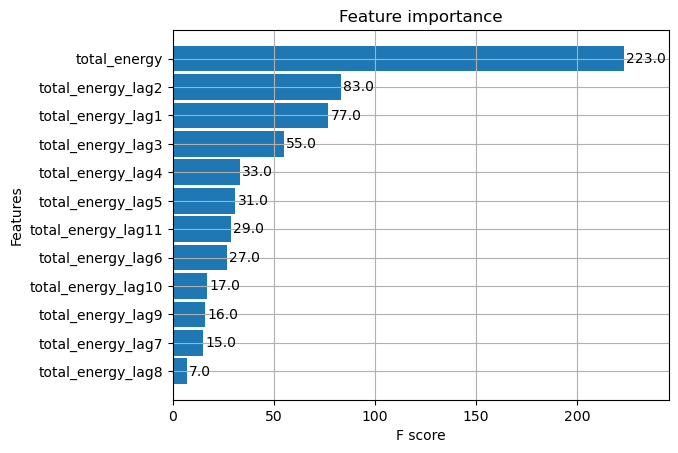

In [94]:
_ = plot_importance(reg, height=0.9)

In [96]:
test['pred'] = reg.predict(X_test)
df_all = pd.concat([train, val, test], sort=False)

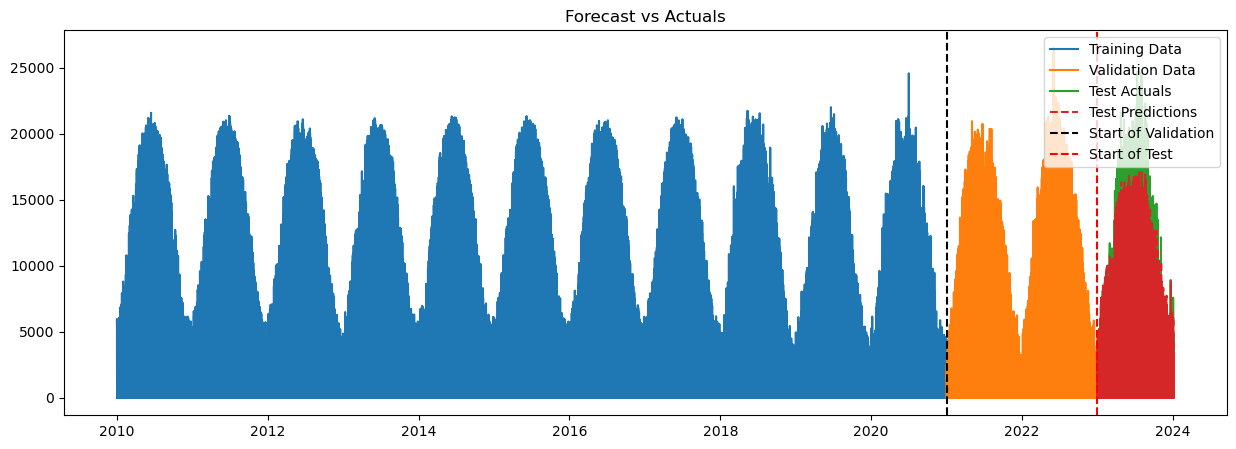

In [99]:
# Visualize the actuals vs predictions
plt.figure(figsize=(15, 5))
plt.plot(train.index, train['y'], label='Training Data')
plt.plot(val.index, val['y'], label='Validation Data')
plt.plot(test.index, test['y'], label='Test Actuals')
plt.plot(test.index, test['pred'], label='Test Predictions', linestyle='--')
plt.axvline(x=val.index.min(), color='black', linestyle='--', label='Start of Validation')
plt.axvline(x=test.index.min(), color='red', linestyle='--', label='Start of Test')
plt.legend()
plt.title('Forecast vs Actuals')
plt.show()

In [102]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate error metrics
mse = mean_squared_error(test['y'], test['pred'])
mae = mean_absolute_error(test['y'], test['pred'])
r2 = r2_score(test['y'], test['pred'])

print(f"MSE: {mse}, MAE: {mae}, R^2: {r2}")


MSE: 7271650.609942389, MAE: 1334.707451950735, R^2: 0.6781745183968892


In [105]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    y_true_filtered = y_true[non_zero_mask]
    y_pred_filtered = y_pred[non_zero_mask]
    return np.mean(np.abs((y_true_filtered - y_pred_filtered) / y_true_filtered)) * 100


In [106]:
mape = mean_absolute_percentage_error(test['y'], test['pred'])
print(f"MAPE: {mape}%")

MAPE: 114.7637739986773%


In [112]:
df_reindexed 

,temp,humidity,windspeed,cloudcover,solarradiation,solarenergy,uvindex,date,year,month,day,time,hour,day_of_week,week_of_year,day_of_year,season,total_energy
2010-01-01 00:00:00,1.9,84.25,19.4,62.2,0.0,0.0,0.0,2010-01-01,2010,1,1,00:00:00,0,4,53,1,1,0.000000
2010-01-01 01:00:00,1.9,83.90,21.8,22.4,0.0,0.0,0.0,2010-01-01,2010,1,1,01:00:00,1,4,53,1,1,0.000000
2010-01-01 02:00:00,1.4,85.76,17.7,38.0,0.0,0.0,0.0,2010-01-01,2010,1,1,02:00:00,2,4,53,1,1,0.000000
2010-01-01 03:00:00,1.4,85.69,18.0,66.7,0.0,0.0,0.0,2010-01-01,2010,1,1,03:00:00,3,4,53,1,1,0.000000
2010-01-01 04:00:00,1.3,85.72,17.4,62.8,0.0,0.0,0.0,2010-01-01,2010,1,1,04:00:00,4,4,53,1,1,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-06 07:00:00,5.1,89.07,9.6,65.1,0.0,0.0,0.0,2024-01-06,2024,1,6,07:00:00,7,5,1,6,1,0.000000
2024-01-06 08:00:00,5.0,90.24,8.9,89.9,0.0,0.0,0.0,2024-01-06,2024,1,6,08:00:00,8,5,1,6,1,0.000000
2024-01-06 09:00:00,4.9,92.89,9.6,85.5,23.0,0.1,0.0,2024-01-06,2024,1,6,09:00:00,9,5,1,6,1,530.543346
2024-01-06 10:00:00,5.9,92.47,7.8,51.7,72.0,0.3,1.0,2024-01-06,2024,1,6,10:00:00,10,5,1,6,1,1660.831344


LSTM

In [127]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Assuming df_reindexed already includes 'total_energy' with all necessary lag features
# Create the target variable for 24 hours ahead
df_lstm['target'] = df_lstm['total_energy'].shift(-24)
df_lstm.dropna(inplace=True)  # Dropping rows where any lag features would be NaN

In [149]:
df_lstm

,temp,humidity,windspeed,cloudcover,solarradiation,solarenergy,uvindex,date,year,month,day,time,hour,day_of_week,week_of_year,day_of_year,season,total_energy
2010-01-01 00:00:00,1.9,84.25,19.4,62.2,0.0,0.00,0.0,2010-01-01,2010,1,1,00:00:00,0,4,53,1,1,0.000000
2010-01-01 01:00:00,1.9,83.90,21.8,22.4,0.0,0.00,0.0,2010-01-01,2010,1,1,01:00:00,1,4,53,1,1,0.000000
2010-01-01 02:00:00,1.4,85.76,17.7,38.0,0.0,0.00,0.0,2010-01-01,2010,1,1,02:00:00,2,4,53,1,1,0.000000
2010-01-01 03:00:00,1.4,85.69,18.0,66.7,0.0,0.00,0.0,2010-01-01,2010,1,1,03:00:00,3,4,53,1,1,0.000000
2010-01-01 04:00:00,1.3,85.72,17.4,62.8,0.0,0.00,0.0,2010-01-01,2010,1,1,04:00:00,4,4,53,1,1,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-04 07:00:00,5.6,87.95,14.8,37.4,0.0,0.00,0.0,2024-01-04,2024,1,4,07:00:00,7,3,1,4,1,0.000000
2024-01-04 08:00:00,5.0,86.90,8.2,25.0,7.0,0.00,0.0,2024-01-04,2024,1,4,08:00:00,8,3,1,4,1,161.469714
2024-01-04 09:00:00,5.1,86.91,1.5,25.0,35.0,0.10,0.0,2024-01-04,2024,1,4,09:00:00,9,3,1,4,1,807.348570
2024-01-04 10:00:00,6.9,92.17,4.3,100.0,105.0,0.15,1.0,2024-01-04,2024,1,4,10:00:00,10,3,1,4,1,2422.045710


In [150]:
for lag in range(1, 25):  # Creating 24 lag features
    df_lstm[f'total_energy_lag_{lag}'] = df_lstm['total_energy'].shift(lag)

df_lstm['target'] = df_lstm['total_energy'].shift(-24)  # Target variable 24 hours into the future
df_lstm = df_lstm.dropna()  # Drop rows with NaN values created by lagging

In [151]:
# Dropping non-numerical or unnecessary columns
df_lstm.drop(columns=['date', 'time'], inplace=True)


In [152]:
from sklearn.preprocessing import MinMaxScaler

# Selecting numerical columns (assuming all remaining are numerical)
features = df_lstm.drop(columns=['target']).columns
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit scaler on features and transform
df_lstm[features] = scaler.fit_transform(df_lstm[features])
# Scale the target separately
target_scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm['target'] = target_scaler.fit_transform(df_lstm[['target']])


In [153]:
# Defining indices for train, validation, and test sets
train = df_lstm[:'2020']
validation = df_lstm['2021':'2022']
test = df_lstm['2023':]

# Prepare input-output pairs
X_train, y_train = train[features], train['target']
X_val, y_val = validation[features], validation['target']
X_test, y_test = test[features], test['target']

# Reshape features for LSTM [samples, time steps, features]
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.values.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))


In [154]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM model architecture
model = Sequential([
    LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(25, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=2, shuffle=False)


Epoch 1/50
3013/3013 - 11s - loss: 0.0075 - val_loss: 0.0098 - 11s/epoch - 4ms/step
Epoch 2/50
3013/3013 - 7s - loss: 0.0070 - val_loss: 0.0089 - 7s/epoch - 2ms/step
Epoch 3/50
3013/3013 - 6s - loss: 0.0069 - val_loss: 0.0085 - 6s/epoch - 2ms/step
Epoch 4/50
3013/3013 - 7s - loss: 0.0067 - val_loss: 0.0082 - 7s/epoch - 2ms/step
Epoch 5/50
3013/3013 - 7s - loss: 0.0066 - val_loss: 0.0079 - 7s/epoch - 2ms/step
Epoch 6/50
3013/3013 - 8s - loss: 0.0066 - val_loss: 0.0077 - 8s/epoch - 3ms/step
Epoch 7/50
3013/3013 - 9s - loss: 0.0066 - val_loss: 0.0075 - 9s/epoch - 3ms/step
Epoch 8/50
3013/3013 - 9s - loss: 0.0065 - val_loss: 0.0073 - 9s/epoch - 3ms/step
Epoch 9/50
3013/3013 - 7s - loss: 0.0065 - val_loss: 0.0071 - 7s/epoch - 2ms/step
Epoch 10/50
3013/3013 - 7s - loss: 0.0064 - val_loss: 0.0070 - 7s/epoch - 2ms/step
Epoch 11/50
3013/3013 - 8s - loss: 0.0064 - val_loss: 0.0069 - 8s/epoch - 3ms/step
Epoch 12/50
3013/3013 - 7s - loss: 0.0063 - val_loss: 0.0069 - 7s/epoch - 2ms/step
Epoch 13/50

In [155]:
# Making predictions
y_pred_test = model.predict(X_test)


276/276 [==============================] - 1s 953us/step


In [157]:
# Inverse scaling for the target to get interpretable results
y_test_np = y_test.to_numpy().reshape(-1, 1)

y_pred_test_inv = target_scaler.inverse_transform(y_pred_test)
y_test_inv = target_scaler.inverse_transform(y_test_np)


In [158]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate MSE, MAE, and R2
mse = mean_squared_error(y_test_inv, y_pred_test_inv)
mae = mean_absolute_error(y_test_inv, y_pred_test_inv)
r2 = r2_score(y_test_inv, y_pred_test_inv)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R^2 Score: {r2}")


Mean Squared Error (MSE): 5686893.865078242
Mean Absolute Error (MAE): 1271.8142399070027
R^2 Score: 0.7492986256043687


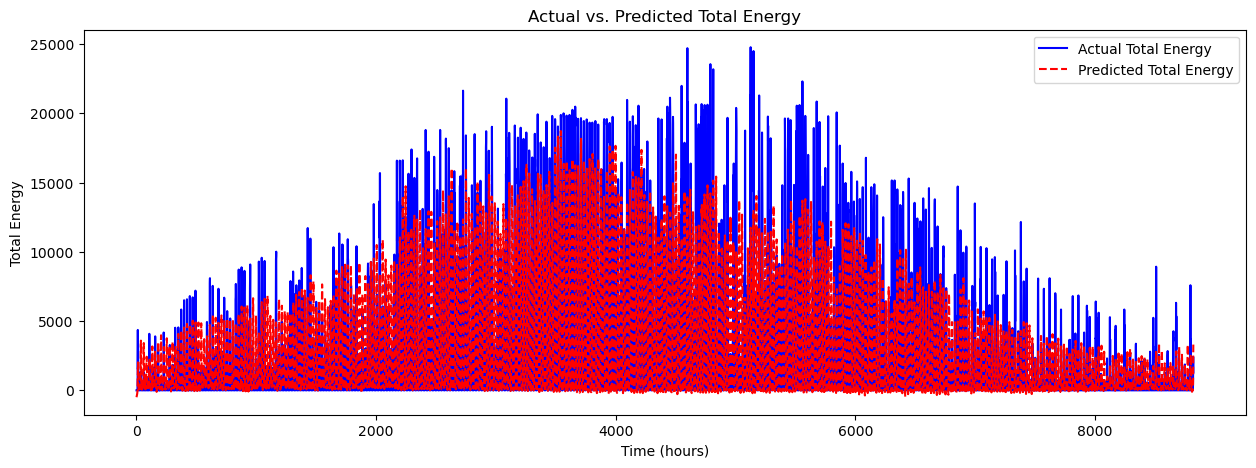

In [159]:
import matplotlib.pyplot as plt

# Plotting actual vs predicted values
plt.figure(figsize=(15, 5))
plt.plot(y_test_inv.flatten(), label='Actual Total Energy', color='blue')
plt.plot(y_pred_test_inv.flatten(), label='Predicted Total Energy', color='red', linestyle='--')
plt.title('Actual vs. Predicted Total Energy')
plt.xlabel('Time (hours)')
plt.ylabel('Total Energy')
plt.legend()
plt.show()


In [162]:
print(type(test_data))  # Should output: <class 'pandas.core.frame.DataFrame'>
print(type(y_pred_test_inv))  # Should output: <class 'numpy.ndarray'>

if isinstance(test_data, pd.DataFrame):
    print(test_data.info())
else:
    print("test_data is not a DataFrame.")

if isinstance(y_pred_test_inv, np.ndarray):
    print("y_pred_test_inv is a numpy array with shape:", y_pred_test_inv.shape)
else:
    print("y_pred_test_inv is not a numpy array.")


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
test_data is not a DataFrame.
y_pred_test_inv is a numpy array with shape: (8820, 1)


In [163]:
test_data = df_lstm['2023':]

In [164]:
timestamps = pd.date_range(start='2023-01-01', periods=len(y_pred_test_inv), freq='H')
test_data = pd.DataFrame(y_pred_test_inv, columns=['Predicted_Energy'], index=timestamps)

In [165]:
# Attach the predicted values to the test DataFrame
test_data['Predicted_Energy'] = y_pred_test_inv.flatten()  # Flatten in case y_pred_test_inv is 2D

# Define a threshold
Real_Threshold = 6191.4

# Filter for surplus energy
surplus_data = test_data[test_data['Predicted_Energy'] > Real_Threshold]

# Display times and predicted energy for surplus
print("Times with energy surplus:")
print(surplus_data.index)
print(surplus_data['Predicted_Energy'])


Times with energy surplus:
DatetimeIndex(['2023-02-10 12:00:00', '2023-02-10 13:00:00',
               '2023-02-13 13:00:00', '2023-02-14 12:00:00',
               '2023-02-14 13:00:00', '2023-02-14 14:00:00',
               '2023-02-15 12:00:00', '2023-02-15 13:00:00',
               '2023-02-15 14:00:00', '2023-02-19 12:00:00',
               ...
               '2023-10-14 12:00:00', '2023-10-14 13:00:00',
               '2023-10-14 14:00:00', '2023-10-15 11:00:00',
               '2023-10-15 12:00:00', '2023-10-15 13:00:00',
               '2023-10-15 14:00:00', '2023-10-16 12:00:00',
               '2023-10-17 12:00:00', '2023-10-17 13:00:00'],
              dtype='datetime64[ns]', length=1662, freq=None)
2023-02-10 12:00:00    6382.590820
2023-02-10 13:00:00    6652.714355
2023-02-13 13:00:00    6370.586426
2023-02-14 12:00:00    6289.483887
2023-02-14 13:00:00    6610.561523
                          ...     
2023-10-15 13:00:00    8098.374023
2023-10-15 14:00:00    7342.218750
2

In [166]:
# Assuming y_pred_test_inv is the predictions array and it's directly comparable to the test data.
print("Shape of predictions:", y_pred_test_inv.shape)
print("Length of test index:", len(test.index))

# Check if the dimensions match
if y_pred_test_inv.shape[0] != len(test.index):
    print("Mismatch in the dimensions!")
else:
    print("Dimensions match.")

# Generate surplus_mask correctly assuming y_pred_test_inv and Real_Threshold are already defined
surplus_mask = y_pred_test_inv > Real_Threshold

# Checking the shape of the mask
print("Shape of surplus_mask:", surplus_mask.shape)

# Apply the mask directly to the DataFrame if possible
if isinstance(test, pd.DataFrame):
    surplus_data = test[surplus_mask]
    print("Surplus data times and values:")
    print(surplus_data)
else:
    # If 'test' is a numpy array and you have a separate time index
    surplus_times = test.index[surplus_mask]  # This line assumes 'test' is a DataFrame with a 'DatetimeIndex'
    print("Times with energy surplus:")
    print(surplus_times)


Shape of predictions: (8820, 1)
Length of test index: 8820
Dimensions match.
Shape of surplus_mask: (8820, 1)
Surplus data times and values:
                         temp  humidity  windspeed  cloudcover  \
2023-02-10 12:00:00  0.403302  0.546920   0.247922       0.000   
2023-02-10 13:00:00  0.417453  0.504626   0.240997       0.013   
2023-02-13 13:00:00  0.443396  0.742004   0.193906       0.086   
2023-02-14 12:00:00  0.441038  0.861089   0.137119       0.409   
2023-02-14 13:00:00  0.457547  0.796193   0.141274       0.030   
...                       ...       ...        ...         ...   
2023-10-15 13:00:00  0.466981  0.392281   0.195291       0.036   
2023-10-15 14:00:00  0.476415  0.371266   0.229917       0.000   
2023-10-16 12:00:00  0.500000  0.573487   0.236842       0.305   
2023-10-17 12:00:00  0.540094  0.453212   0.386427       0.145   
2023-10-17 13:00:00  0.549528  0.388713   0.403047       0.122   

                     solarradiation  solarenergy  uvindex      yea

C:\Users\mrudu\AppData\Local\Temp\ipykernel_23460\2989870991.py:8: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  data_2023 = test_data['2023']


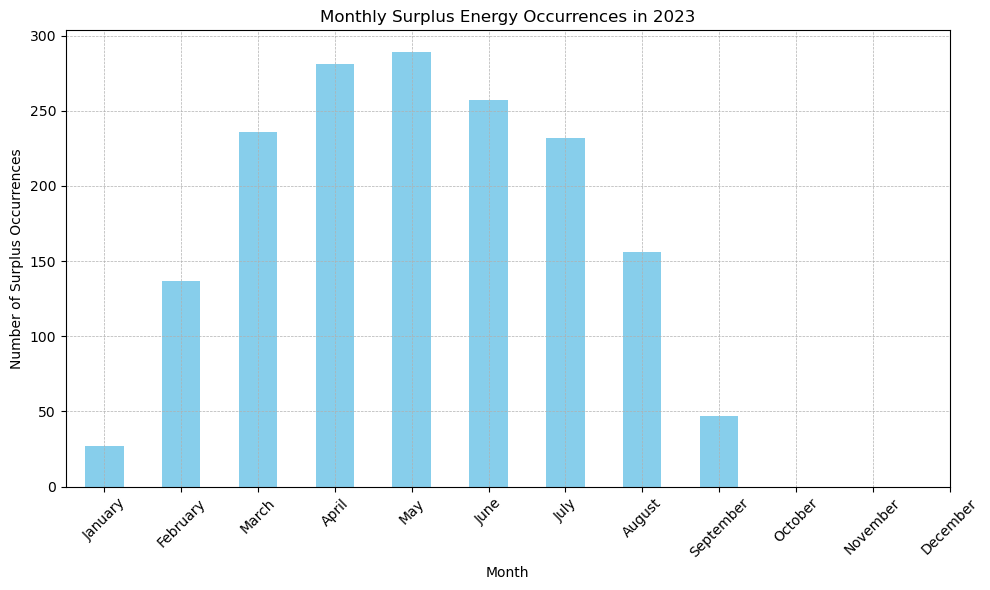

Detailed view of surplus instances:
                     Predicted_Energy  Month
2023-02-10 12:00:00       6382.590820      2
2023-02-28 13:00:00       7036.101562      2
2023-02-28 12:00:00       7205.141602      2
2023-02-28 11:00:00       6624.098145      2
2023-02-27 14:00:00       6938.683105      2
...                               ...    ...
2023-10-05 14:00:00       6542.160156     10
2023-10-06 12:00:00       6578.584961     10
2023-10-06 13:00:00       7104.791992     10
2023-10-07 11:00:00       6719.416992     10
2023-10-17 13:00:00       6393.298340     10

[1662 rows x 2 columns]


In [175]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'test_data' is a pandas DataFrame containing the predictions for 2023 and beyond
# and that it has a datetime index.

# Filter data for 2023
data_2023 = test_data['2023']

# Define the Real Threshold
Real_Threshold = 6191.4

# Find instances where predicted energy exceeds the Real Threshold
surplus_2023 = data_2023[data_2023['Predicted_Energy'] > Real_Threshold]

# Create a month column for grouping
surplus_2023['Month'] = surplus_2023.index.month

# Group by month and count occurrences of surplus
monthly_surplus = surplus_2023.groupby('Month').size()

# Plot the results
plt.figure(figsize=(10, 6))
monthly_surplus.plot(kind='bar', color='skyblue')
plt.title('Monthly Surplus Energy Occurrences in 2023')
plt.xlabel('Month')
plt.ylabel('Number of Surplus Occurrences')
plt.xticks(ticks=range(len(months_of_the_year)), labels=months_of_the_year, rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Display the surplus data sorted by month
print("Detailed view of surplus instances:")
print(surplus_2023.sort_values(by='Month')[['Predicted_Energy', 'Month']])


C:\Users\mrudu\AppData\Local\Temp\ipykernel_23460\2393269114.py:6: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  data_2023 = test_data['2023']


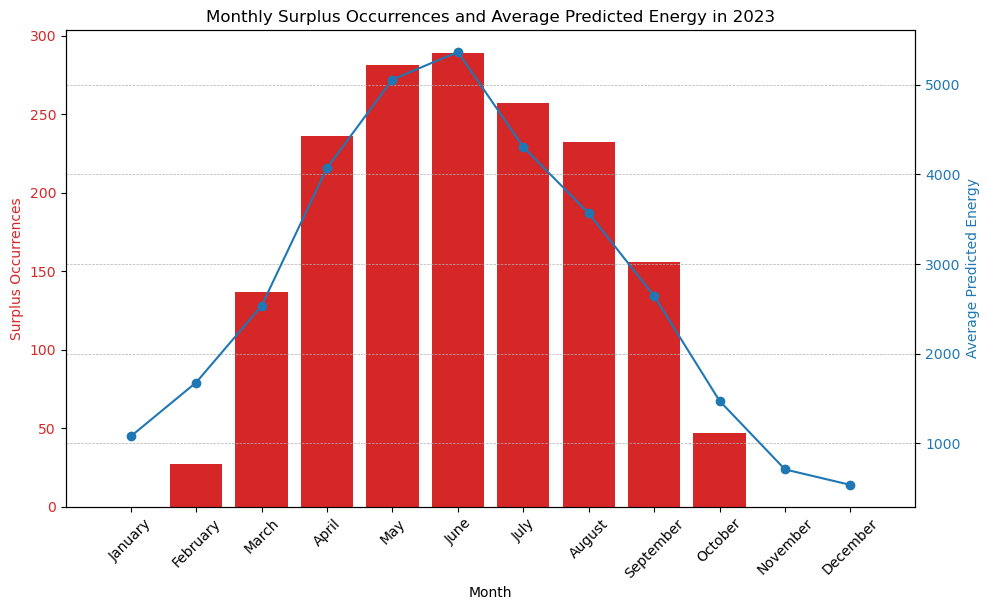

In [176]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'test_data' has a datetime index and includes the year 2023
# Filter data for the year 2023
data_2023 = test_data['2023']

# Define the Real Threshold
Real_Threshold = 6191.4

# Identify where predictions exceed the Real Threshold
data_2023['Surplus'] = data_2023['Predicted_Energy'] > Real_Threshold

# Group data by month for surplus occurrences and average predicted energy
monthly_data = data_2023.groupby(data_2023.index.month).agg(
    Surplus_Occurrences=('Surplus', 'sum'),  # Count of True values for surplus
    Average_Predicted_Energy=('Predicted_Energy', 'mean')  # Average of predicted energies
)

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for surplus occurrences
color = 'tab:red'
ax1.set_xlabel('Month')
ax1.set_ylabel('Surplus Occurrences', color=color)
ax1.bar(monthly_data.index, monthly_data['Surplus_Occurrences'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(range(1, 13))  # Ensure all months are shown
ax1.set_xticklabels(months_of_the_year, rotation=45)

# Line plot for average predicted energy
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Average Predicted Energy', color=color)  # we already handled the x-label with ax1
ax2.plot(monthly_data.index, monthly_data['Average_Predicted_Energy'], color=color, marker='o', linestyle='-')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Monthly Surplus Occurrences and Average Predicted Energy in 2023')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


C:\Users\mrudu\AppData\Local\Temp\ipykernel_23460\3152077515.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  data_2023 = test_data['2023']


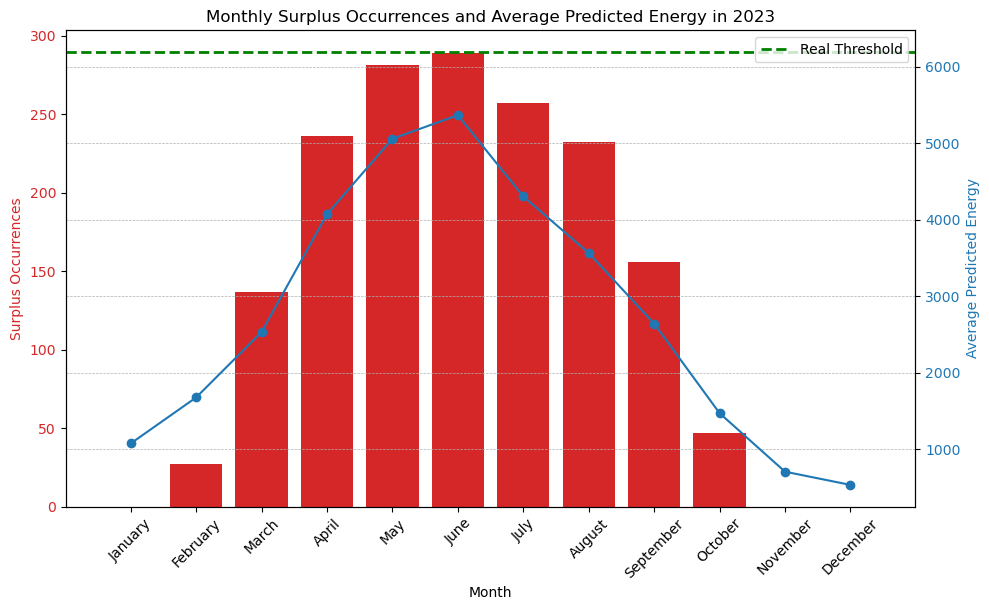

In [177]:
import matplotlib.pyplot as plt
import pandas as pd

# Filter data for the year 2023
data_2023 = test_data['2023']

# Define the Real Threshold
Real_Threshold = 6191.4

# Identify where predictions exceed the Real Threshold
data_2023['Surplus'] = data_2023['Predicted_Energy'] > Real_Threshold

# Group data by month for surplus occurrences and average predicted energy
monthly_data = data_2023.groupby(data_2023.index.month).agg(
    Surplus_Occurrences=('Surplus', 'sum'),  # Count of True values for surplus
    Average_Predicted_Energy=('Predicted_Energy', 'mean')  # Average of predicted energies
)

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for surplus occurrences
color = 'tab:red'
ax1.set_xlabel('Month')
ax1.set_ylabel('Surplus Occurrences', color=color)
ax1.bar(monthly_data.index, monthly_data['Surplus_Occurrences'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(range(1, 13))  # Ensure all months are shown
ax1.set_xticklabels(months_of_the_year, rotation=45)

# Line plot for average predicted energy
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Average Predicted Energy', color=color)  # we already handled the x-label with ax1
ax2.plot(monthly_data.index, monthly_data['Average_Predicted_Energy'], color=color, marker='o', linestyle='-')
ax2.tick_params(axis='y', labelcolor=color)

# Draw a horizontal line for the Real Threshold
ax2.axhline(y=Real_Threshold, color='green', linestyle='--', linewidth=2, label='Real Threshold')
ax2.legend(loc='upper right')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Monthly Surplus Occurrences and Average Predicted Energy in 2023')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()
